# Penguins in Production

This notebook creates a [SageMaker Pipeline](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_building_pipeline.html) to build an end-to-end Machine Learning system to solve the problem of classifying penguin species. With a SageMaker Pipeline, you can create, automate, and manage end-to-end Machine Learning workflows at scale.

You can find more information about Amazon SageMaker in the [Amazon SageMaker Developer Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/whatis.html). The [AWS Machine Learning Blog](https://aws.amazon.com/blogs/machine-learning/) is an excellent source to stay up-to-date with SageMaker.

This example uses the [Penguins dataset](https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data), the [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html) library, and the [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/). 

<img src='https://imgur.com/orZWHly.png' alt='Penguins dataset' width="800">

## Table of Contents

1. [Session 1 - Production Machine Learning is Different](#Session-1---Production-Machine-Learning-is-Different) 
2. [Session 2 - Implementing a Production Pipeline](#Session-2---Implementing-a-Production-Pipeline)
3. [Session 3 - Building a Model](#Session-3---Building-a-Model)
4. [Session 4 - Evaluating and Registering The Model](#Session-4---Evaluating-and-Registering-The-Model)
5. [Session 5 - Deploying The Model](#Session-5---Deploying-The-Model)
6. [Session 6 - Monitoring](#Session-6---Monitoring)
7. [Running the Pipeline](#Running-the-Pipeline)

This notebook is part of the [Machine Learning School](https://www.ml.school) program.

<div class="alert" style="background-color:#6e420c; color: #fff"><strong>Note:</strong> 
    Make sure you run the <strong><a href="penguins-setup.ipynb" style="color: #0397a7">Setup notebook</a></strong> once at the start of the program and before running this notebook. After doing that, ensure you are using a "TensorFlow 2.6 Python 3.8 CPU Optimized" image and the "packages" start-up script to run this notebook.
</div>

In [398]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

CODE_FOLDER = Path("code")
CODE_FOLDER.mkdir(parents=True, exist_ok=True)

sys.path.append(f"./{CODE_FOLDER}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Session 1 - Production Machine Learning is Different

In this session we'll run Exploratory Data Analysis on the [Penguins dataset](https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data). We'll split and transform the data using a [Scikit-Learn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

In [399]:
import boto3
import logging
import numpy as np
import tensorflow as tf
import urllib.request
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import sagemaker
import sklearn

from plotly.subplots import make_subplots
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sagemaker.s3 import S3Uploader

# By default, The SageMaker SDK logs events related to the default
# configuration using the INFO level. To prevent these from spoiling
# the output of this notebook cells, we can change the logging
# level to ERROR instead.
logging.getLogger("sagemaker.config").setLevel(logging.ERROR)

## Step 1 - Upload Dataset to S3

Let's create the S3 bucket where we will organize every resource we are going to use during the program.

<div class="alert" style="background-color:#6e420c; color: #fff"><strong>Note:</strong> 
    You need to select a unique name for the <strong>BUCKET</strong> constant. If you want to create a bucket in a region other than <strong>us-east-1</strong>, you need to use the "--create-bucket-configuration" argument when creating the bucket. You can see an example below.
</div>

Example of how to specify a region different from `us-east-1` when creating a bucket:

```
!aws s3api create-bucket --bucket $BUCKET --create-bucket-configuration LocationConstraint="eu-west-1"
```

The `LocationConstraint` argument should specify the region where you want to create the bucket. The example above creates the bucket in the `eu-west-1` region.

In [400]:
BUCKET = "mlschool"

!aws s3api create-bucket --bucket $BUCKET

{
    "Location": "/mlschool"
}


After we have a bucket, we can download the [Penguins dataset](https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data) and store it in the bucket.

In [401]:
S3_LOCATION = f"s3://{BUCKET}/penguins"
DATA_FILEPATH = Path().resolve() / "data.csv"

urllib.request.urlretrieve(
    "https://storage.googleapis.com/download.tensorflow.org/data/palmer_penguins/penguins_size.csv", 
    DATA_FILEPATH
)

S3Uploader.upload(local_path=str(DATA_FILEPATH), desired_s3_uri=S3_LOCATION)

's3://mlschool/penguins/data.csv'

## Step 2 - Analyzing the Dataset

Let's load the Penguins dataset. 

The dataset contains the following columns:

1. `species`: The species of a penguin. This is the column we want to predict.
2. `island`: The island where the penguin was found
3. `culmen_length_mm`: The length of the penguin's culmen (bill) in millimeters
4. `culmen_depth_mm`: The depth of the penguin's culmen in millimeters
5. `flipper_length_mm`: The length of the penguin's flipper in millimeters
6. `body_mass_g`: The body mass of the penguin in grams
7. `sex`: The sex of the penguin

In [402]:
penguins = pd.read_csv(DATA_FILEPATH)
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


Now, let's get the summary statistics for the features in our dataset.

In [403]:
penguins.describe(include='all')

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,342.000000,342.000000,342.000000,342.000000,334
unique,3,3,NaN,NaN,NaN,NaN,3
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,MALE
freq,152,168,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.921930,17.151170,200.915205,4201.754386,NaN
std,NaN,NaN,5.459584,1.974793,14.061714,801.954536,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.225000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.450000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.500000,18.700000,213.000000,4750.000000,NaN


The distribution of the categories in our dataset are:

- `species`: There are 3 species of penguins in the dataset: Adelie (152), Gentoo (124), and Chinstrap (68).
- `island`: Penguins are from 3 islands: Biscoe (168), Dream (124), and Torgersen (52).
- `sex`: We have 168 male penguins, 165 female penguins, and 1 penguin with an ambiguous gender ('.').

In [404]:
species_distribution = penguins['species'].value_counts()
island_distribution = penguins['island'].value_counts()
sex_distribution = penguins['sex'].value_counts()

print(species_distribution)
print()
print(island_distribution)
print()
print(sex_distribution)

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

Biscoe       168
Dream        124
Torgersen     52
Name: island, dtype: int64

MALE      168
FEMALE    165
.           1
Name: sex, dtype: int64


Let's replace the ambiguous value in the `sex` column with a null value.

In [405]:
penguins["sex"] = penguins["sex"].replace(".", np.nan)
penguins["sex"].value_counts()

MALE      168
FEMALE    165
Name: sex, dtype: int64

Next, let's check for any missing values in the dataset.

In [406]:
penguins.isnull().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

Let's get rid of the missing values. For now, we are going to replace the missing values with the most frequent value in the column. Later, we'll use a different strategy to replace missing numeric values.

In [407]:
imputer = SimpleImputer(strategy="most_frequent")
penguins.iloc[:,:] = imputer.fit_transform(penguins)
penguins.isnull().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

Let's visualize the distribution of categorical features.

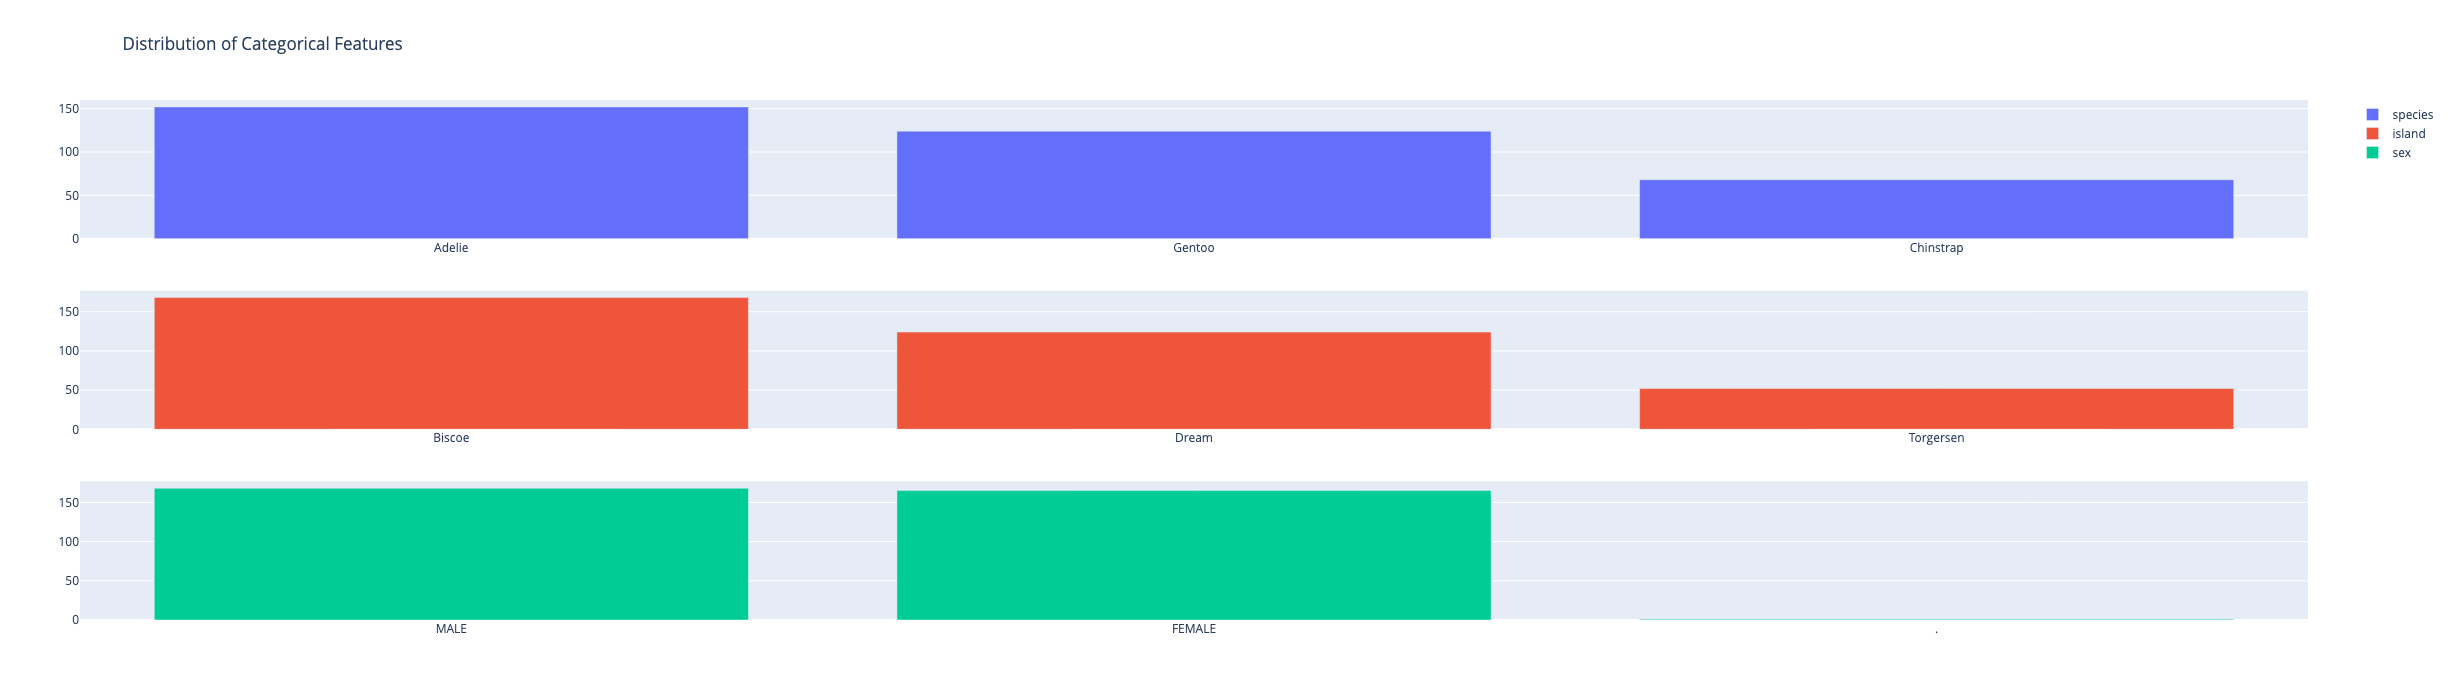

In [408]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Bar(x=species_distribution.index, y=species_distribution.values, name='species'), row=1, col=1)
fig.add_trace(go.Bar(x=island_distribution.index, y=island_distribution.values, name='island'), row=2, col=1)
fig.add_trace(go.Bar(x=sex_distribution.index, y=sex_distribution.values, name='sex'), row=3, col=1)

fig.update_layout(height=700, width=960, title_text="Distribution of Categorical Features")
fig.show()

Let's visualize the distribution of numerical columns.

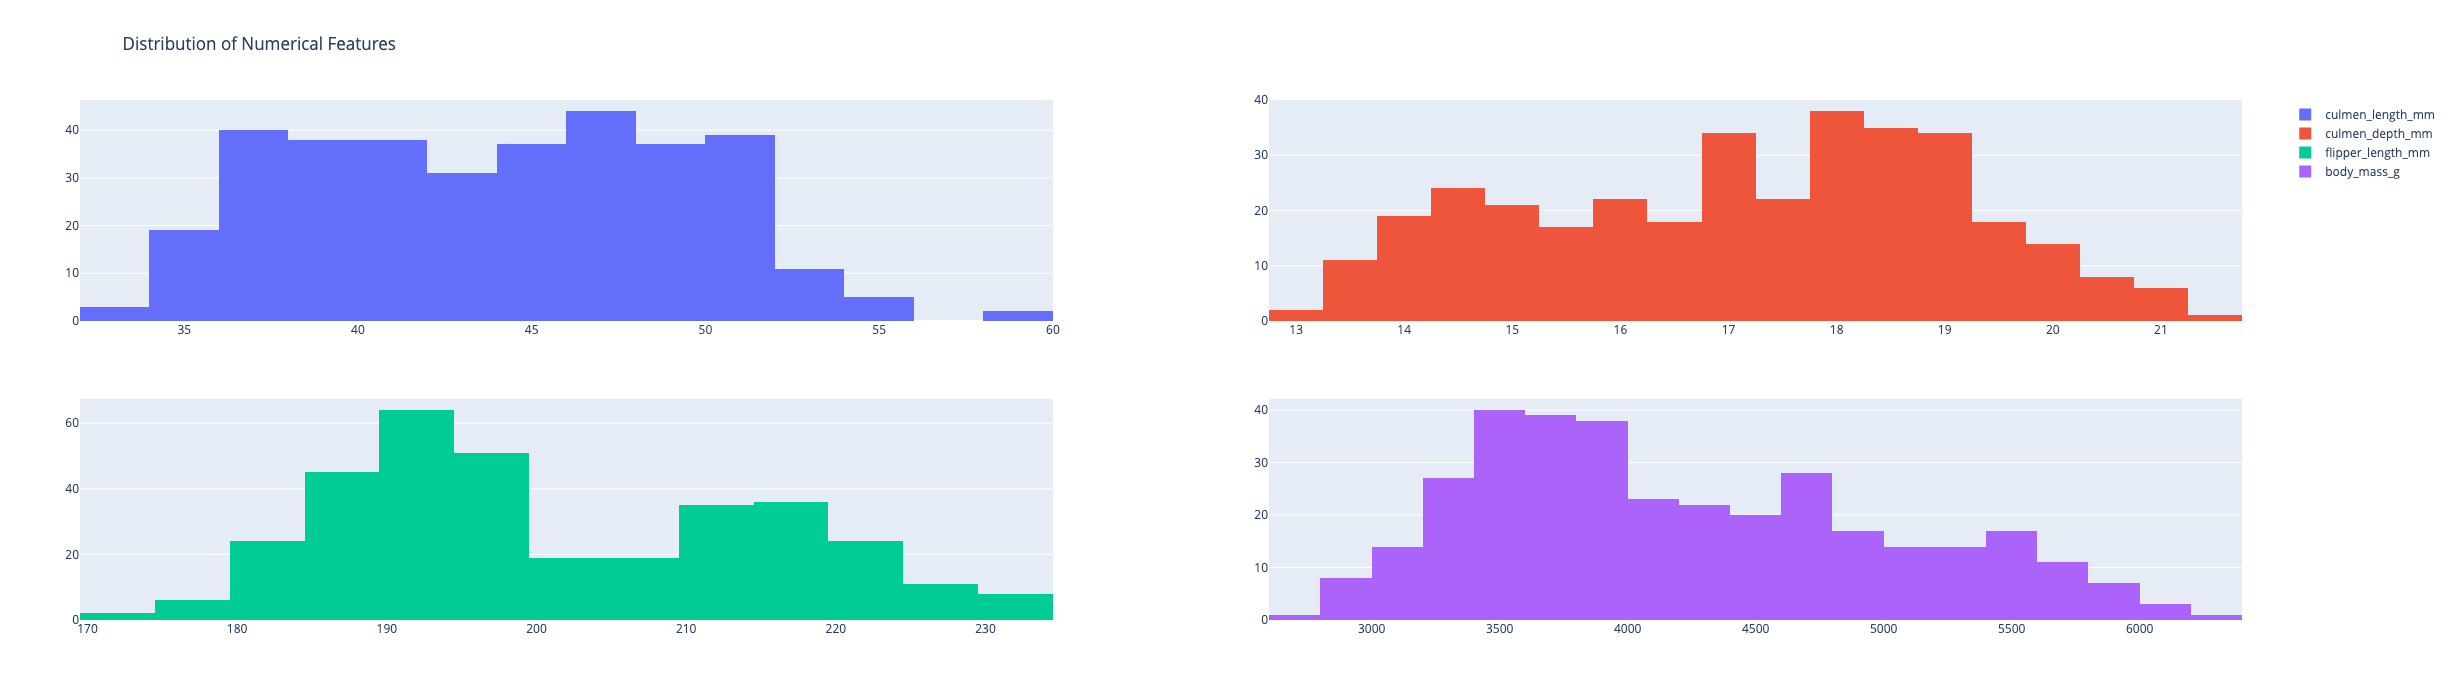

In [409]:
fig = make_subplots(rows=2, cols=2)

fig.add_trace(go.Histogram(x=penguins['culmen_length_mm'], name='culmen_length_mm', nbinsx=20), row=1, col=1)
fig.add_trace(go.Histogram(x=penguins['culmen_depth_mm'], name='culmen_depth_mm', nbinsx=20), row=1, col=2)
fig.add_trace(go.Histogram(x=penguins['flipper_length_mm'], name='flipper_length_mm', nbinsx=20), row=2, col=1)
fig.add_trace(go.Histogram(x=penguins['body_mass_g'], name='body_mass_g', nbinsx=20), row=2, col=2)
fig.update_layout(height=700, width=960, title_text="Distribution of Numerical Features")

fig.show()

Let's display a scatter matrix with every numeric feature from our dataset.

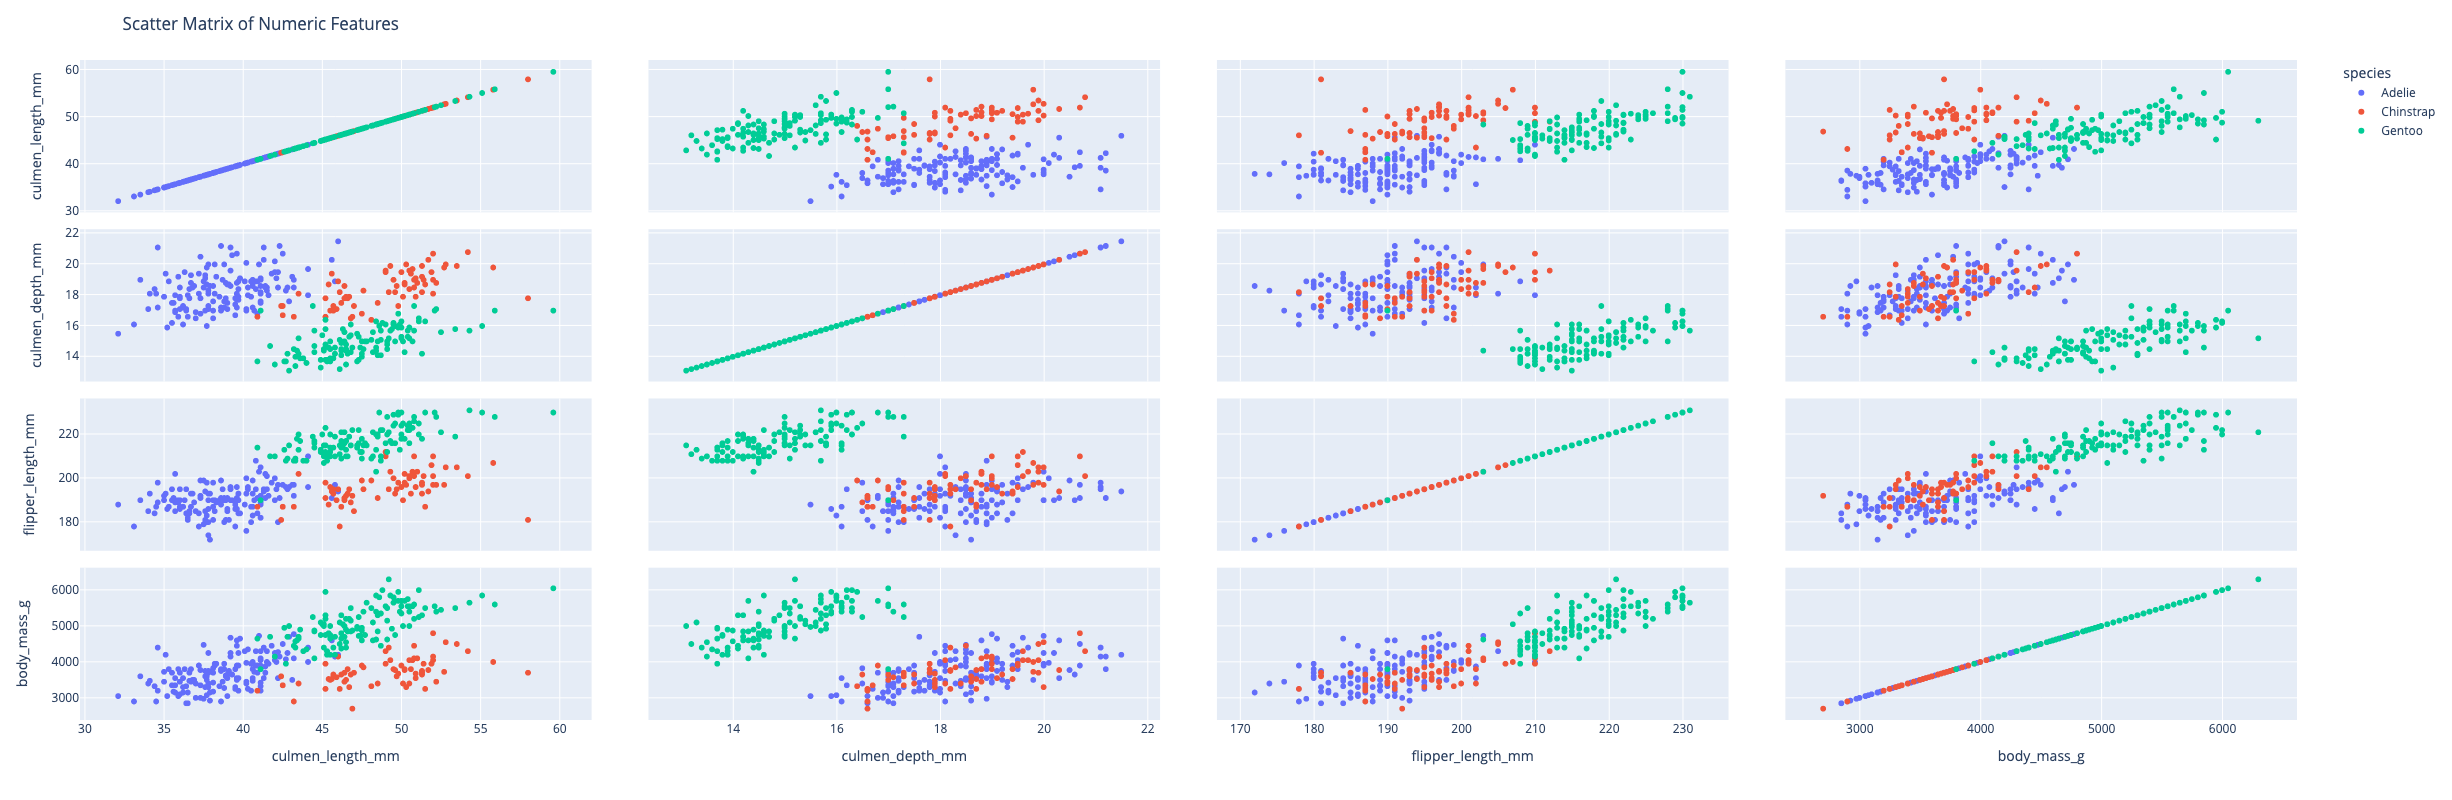

In [410]:
fig = px.scatter_matrix(
    penguins, 
    dimensions=["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "body_mass_g"], 
    color="species")

fig.update_layout(height=800, width=960, title_text="Scatter Matrix of Numeric Features")

fig.show()

Let's display the covariance matrix of the dataset. The "covariance" measures how changes in one variable are associated with changes in a second variable. In other words, the covariance measures the degree to which two variables are linearly associated.

Here are three examples of what we get from interpreting the covariance matrix below:

1. Penguins that weight more tend to have a larger culmen.
2. The more a penguin weights, the shallower its culmen tends to be.
3. There's a small variance between the culmen depth of penguins.

In [411]:
penguins.cov()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,29.679415,-2.516984,50.260588,2596.971151
culmen_depth_mm,-2.516984,3.877201,-16.108849,-742.660180
flipper_length_mm,50.260588,-16.108849,197.269501,9792.552037
body_mass_g,2596.971151,-742.660180,9792.552037,640316.716388


Let's now display the correlation matrix. "Correlation" measures both the strength and direction of the linear relationship between two variables.

Here are three examples of what we get from interpreting the correlation matrix below:

1. Penguins that weight more tend to have larger flippers.
2. Penguins with a shallower culmen tend to have larger flippers.
3. The length and depth of the culmen have a slight negative correlation.

In [412]:
penguins.corr()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,1.000000,-0.234635,0.656856,0.595720
culmen_depth_mm,-0.234635,1.000000,-0.582472,-0.471339
flipper_length_mm,0.656856,-0.582472,1.000000,0.871302
body_mass_g,0.595720,-0.471339,0.871302,1.000000


Let's display the distribution of species by island.

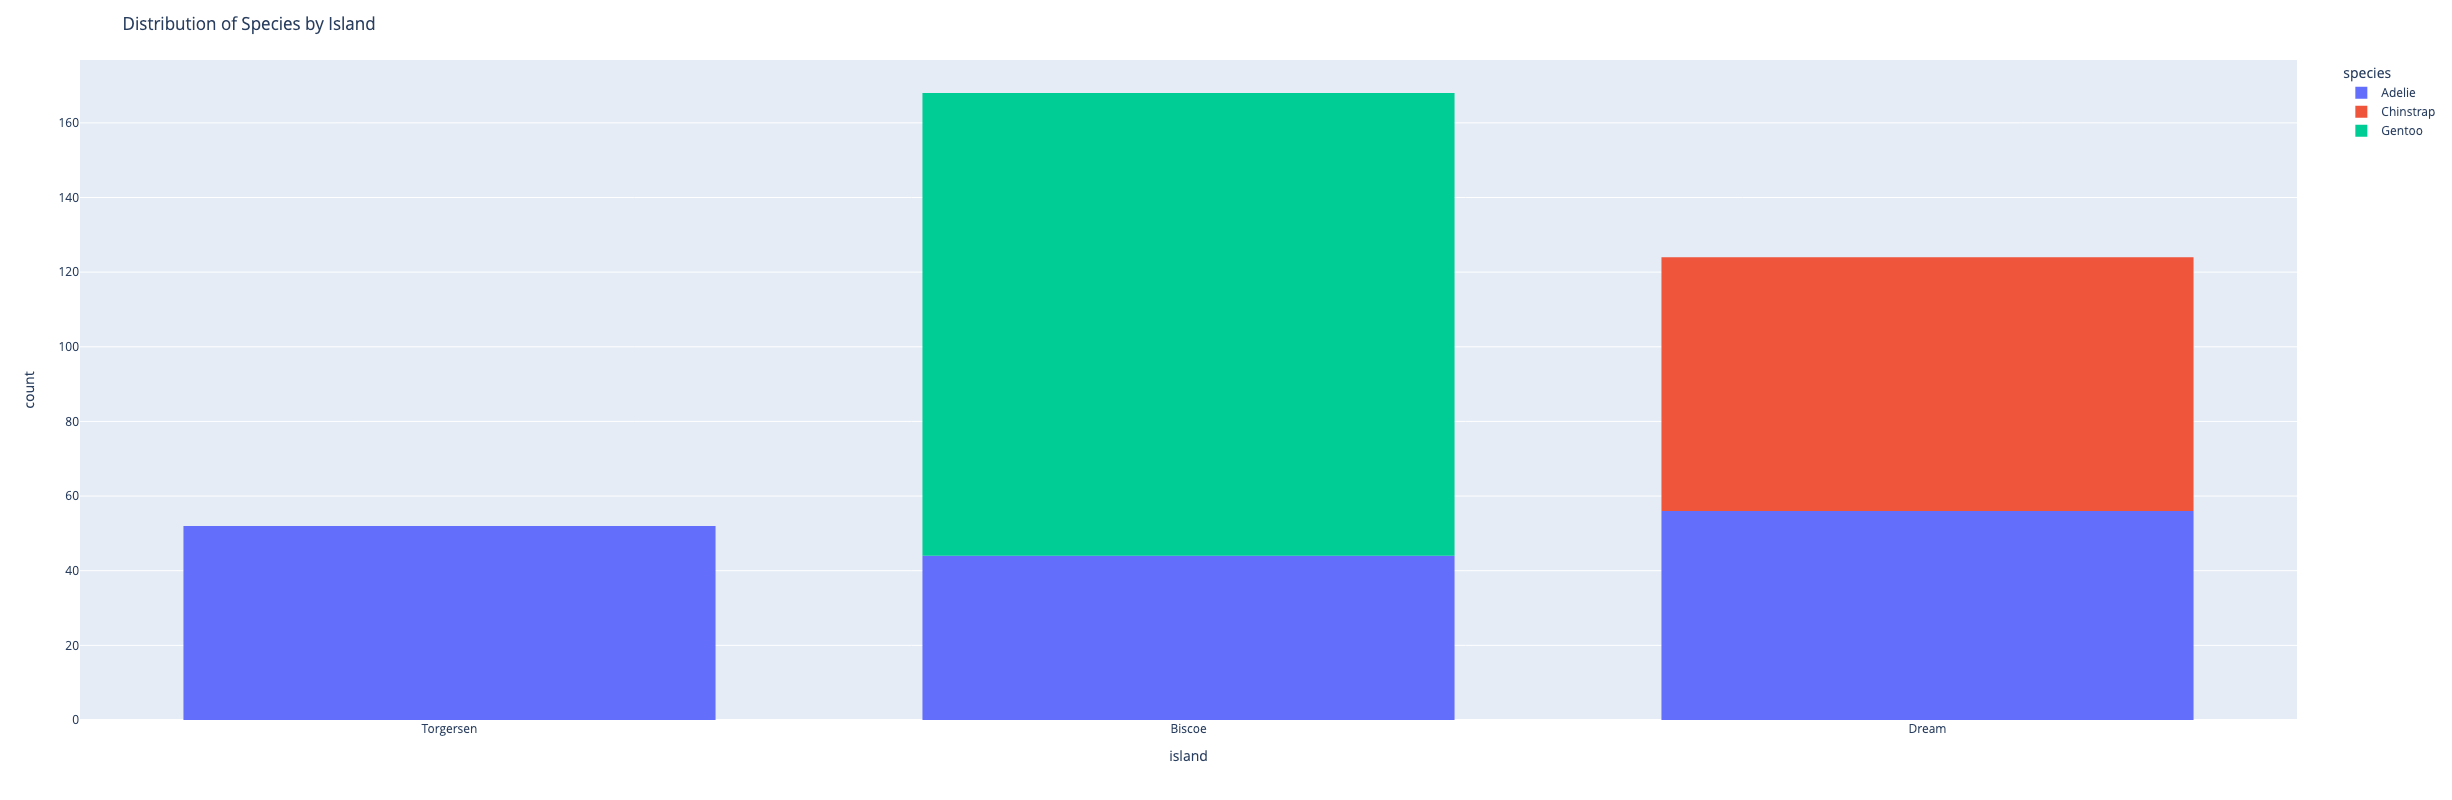

In [413]:
fig = px.histogram(penguins, x="island", color="species", nbins=50)

fig.update_layout(
    height=800, 
    width=960, 
    title_text="Distribution of Species by Island",
    xaxis_title_text='island',
    yaxis_title_text='count',
    bargap=0.2,
    bargroupgap=0.1
)

fig.show()

Let's display the distribution of species by sex.

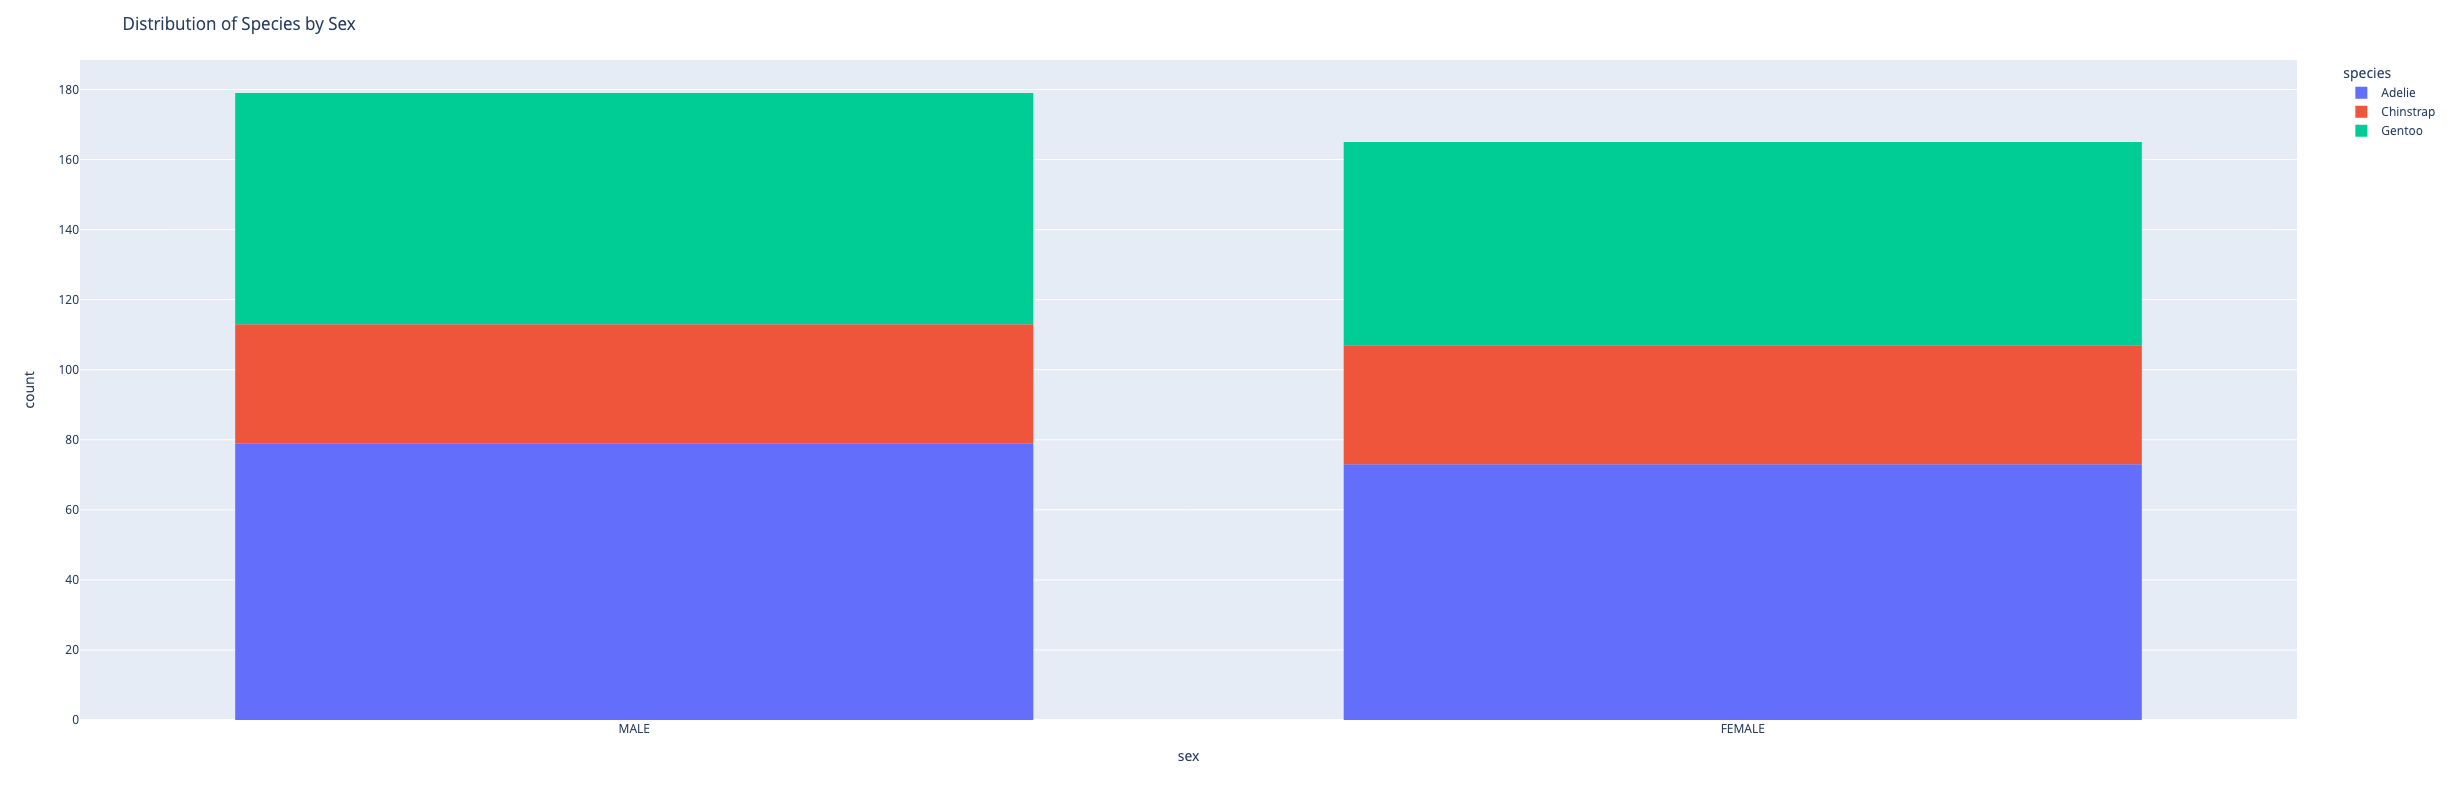

In [414]:
fig = px.histogram(penguins, x="sex", color="species", nbins=50)

fig.update_layout(
    height=800, 
    width=960, 
    title_text="Distribution of Species by Sex",
    xaxis_title_text='sex',
    yaxis_title_text='count',
    bargap=0.2,
    bargroupgap=0.1
)

fig.show()

## Step 3 - Building a Scikit-Learn Pipeline

Let's create a Scikit-Learn pipeline to transform the dataset. Here are the transformations that will happen when we use this pipeline:

* Numeric columns: First, we will impute any missing values using the mean of the column. Then, we will scale the values using a standard scaler.
* Categorical columns: First, we will impute any missing values using the value that shows up more frequently in the data. Then, we will one-hot encode the column.

In [415]:
numeric_features = penguins.select_dtypes(include=["float64"]).columns.tolist()
numeric_transformer = sklearn.pipeline.Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = sklearn.pipeline.Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, ["island"]),        
    ]
)

pipeline = sklearn.pipeline.Pipeline(
    steps=[
        ("preprocessing", preprocessor)
    ]
)

We can display a diagram of our pipeline.

In [416]:
set_config(display="diagram")
pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['culmen_length_mm',
                                                   'culmen_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['island'])]))])

## Step 4 - Splitting and Transforming the Dataset

Now it's time to split and transform the dataset.

Before we split the dataset, let's remove the `sex` column because we don't need it to create a model.

In [417]:
penguins.drop(["sex"], axis=1, inplace=True)

Now, we can shuffle the data.

In [418]:
penguins = penguins.sample(frac=1, random_state=42)

Let's now split the dataset. We want to create three different sets:

* `train`: We'll use this data to train the model. It will have 70% of the samples.
* `validation`: We'll use this data to validate the model during the training process. It will have 15% of the samples.
* `test`: We'll use this data to test the model once is done. It will have 15% of the samples.

In [419]:
penguins_train, temp = train_test_split(penguins, test_size=0.3)
penguins_validation, penguins_test = train_test_split(temp, test_size=0.5)

print(penguins_train.shape)
print(penguins_validation.shape)
print(penguins_test.shape)

(240, 6)
(52, 6)
(52, 6)


We can now transform each of the splits.

First, we encode the target column. This will turn the species column into a numerical value (0, 1, and 2.) Then we remove the target column from the rest of the columns, and run the Scikit-Learn pipeline.

Notice the following about the way we use the pipeline:

* First, we use the `fit_transform()` function to fit the pipeline on the train set.
* Then, we consecutively transform the validation and test sets using the `transform()` function.

Always use `fit_transform()` on the training data to fit the scaling parameters we need to transform the data. For example, `fit_transform()` will learn the mean and variance of the features of the training set. It can then use these same parameters to scale the validation and test sets.

In [420]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(penguins_train.species)
y_validation = label_encoder.transform(penguins_validation.species)
y_test = label_encoder.transform(penguins_test.species)

X_train = penguins_train.drop(["species"], axis=1)
X_validation = penguins_validation.drop(["species"], axis=1)
X_test = penguins_test.drop(["species"], axis=1)

X_train = pipeline.fit_transform(X_train)
X_validation = pipeline.transform(X_validation)
X_test = pipeline.transform(X_test)

X_train.shape

(240, 7)

Let's save each set to disk. Notice that we concatenate the features with the target column before saving the data.

In [421]:
datasets = Path("datasets")
datasets.mkdir(parents=True, exist_ok=True)

train = np.concatenate((X_train, np.expand_dims(y_train, axis=1)), axis=1)
validation = np.concatenate((X_validation, np.expand_dims(y_validation, axis=1)), axis=1)
test = np.concatenate((X_test, np.expand_dims(y_test, axis=1)), axis=1)

pd.DataFrame(train).to_csv(datasets / "train.csv", header=False, index=False)
pd.DataFrame(validation).to_csv(datasets / "validation.csv", header=False, index=False)
pd.DataFrame(test).to_csv(datasets / "test.csv", header=False, index=False)

## Questions

Answering these questions will help you understand the material we discussed during this session. Notice that each question could have one or more correct answers.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 1.1</strong></span></div>

What will happen if we apply the SciKit-Learn transformation pipeline to the entire dataset before splitting it?

1. Scaling will use the global statistics of the dataset, leaking the mean and variance of the test samples into the training process.
2. Imputing the missing numeric values will use the global mean, leading to data leakage.
3. The transformation pipeline expects multiple sets so it wouldn't work.
4. We will reduce the number of lines of code we need to transform the dataset.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 1.2</strong></span></div>

A hospital wants to predict which patients are prone to get a disease based on their medical history. They use weak supervision to automatically label the data using a set of heuristics. What are some of the disadvantages of weak supervision?

1. Weak supervision doesn't scale to large datasets.
2. Weak supervision doesn't adapt well to any changes that require relabeling.
3. Weak supervision produces noisy labels.
4. We might not be able to use weak supervision to label every data sample.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 1.3</strong></span></div>

When collecting the information about the penguins, the scientists encountered a few rare species. To prevent these samples from not showing when splitting the data, they recommended using Stratified Sampling. Which of the following statements about Stratified Sampling are correct?

1. Stratified Sampling assigns every sample of the population an equal chance of being selected.
2. Stratified Sampling preserves the original distribution of different groups in the data.
3. Stratified Sampling requires having a larger dataset compared to Random Sampling.
4. Stratified Sampling can't be used when is not possible to divide all samples into groups.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 1.4</strong></span></div>

Using more features to build a model will not necessarily lead to better predictions. Which of the following are drawbacks from adding more features?

1. More features in a dataset increases the opportunity for data leakage.
2. More features in a dataset increases the opportunity for overfitting.
3. More features in a dataset increases the memory necessary to serve a model.
4. More features in a dataset increases the development and maintenance time of a model. 


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 1.5</strong></span></div>

A bank wants to store every transaction they handle in a set of files in the cloud. Each file will contain the transactions generated in a day. The team who will manage these files wants to optimize the storage space and downloding speed. What format should the bank use to store the transactions?

1. The bank should store the data in JSON format.
2. The bank should store the data in CSV format.
3. The bank should store the data in Parquet format.
4. The bank should store the data in Pandas format.


## Assignments


* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 1.1</strong></span> Familiarize yourself with the dataset we used to kick start the project. Extend the Exploratory Data Analysis in this notebook with any other analysis that you consider interesting.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 1.2</strong></span> The code in this session removes the `sex` column from the dataset before transforming the data. Modify the Scikit-Learn Pipeline to include an additional step that removes the `sex` column.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 1.3</strong></span> The code in this session uses Random Sampling to split the dataset. Modify the code to use Stratified Sampling instead.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 1.4</strong></span> You can use [Amazon SageMaker Data Wrangler](https://aws.amazon.com/sagemaker/data-wrangler/) to complete each step of the data preparation workflow (including data selection, cleansing, exploration, visualization, and processing at scale) from a single visual interface. For this assignment, load the Data Wrangler interface and use it to build the same transformations we implemented using the Scikit-Learn Pipeline. If you have questions, open the [Penguins Data Flow](penguins.flow) included in this repository.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 1.5</strong></span> You can use [Amazon SageMaker Ground Truth](https://aws.amazon.com/sagemaker/data-labeling/) to label data and generate labeled synthetic data. You can configure the service to use workers from either Amazon Mechanical Turk, a vendor company, or an internal, private workforce along with machine learning to enable you to create a labeled dataset. For this assignment, familiarize yourself with the service and setup a simple "Text Classification (Multi-label)" labeling job.


# Session 2 - Implementing a Production Pipeline

In this session we'll build a simple [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with one step to preprocess the data.

We'll use a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) with a [SKLearnProcessor](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) to execute a preprocessing script. Check the [SageMaker Pipelines Overview](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) for an introduction to the fundamental components of a SageMaker Pipeline.

In [422]:
import os
import json
import tempfile

from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.workflow.steps import ProcessingStep
from sagemaker.workflow.parameters import ParameterString
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.steps import CacheConfig
from sagemaker.workflow.pipeline_definition_config import PipelineDefinitionConfig
from sagemaker.workflow.pipeline_context import PipelineSession

pipeline_session = PipelineSession(default_bucket=BUCKET)
sagemaker_session = sagemaker.session.Session()

pipeline_definition_config = PipelineDefinitionConfig(use_custom_job_prefix=True)
sagemaker_client = boto3.client("sagemaker")
iam_client = boto3.client("iam")
role = sagemaker.get_execution_role()
region = boto3.Session().region_name


## Step 1 - Creating the Preprocessing Script

We need to create a script to transform and split the dataset. This is the script that we'll run using the Processing Job.

The script will save the Scikit-Learn pipeline that we use to preprocess the data and the list of target classes.

In [423]:
%%writefile {CODE_FOLDER}/preprocessor.py

import os
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from pickle import dump


# This is the location where the SageMaker Processing job
# will save the input dataset.
BASE_DIRECTORY = "/opt/ml/processing"
DATA_FILEPATH = Path(BASE_DIRECTORY) / "input" / "data.csv"


def preprocess(base_directory, data_filepath):
    """
    Preprocesses the supplied raw dataset and splits it into a train,
    validation, and a test set.
    """

    df = pd.read_csv(data_filepath)

    numeric_features = df.select_dtypes(include=['float64']).columns.tolist()
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler()),
        ]
    )

    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder()),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("numeric", numeric_transformer, numeric_features),
            ("categorical", categorical_transformer, ["island"]),
        ]
    )

    pipeline = Pipeline(
        steps=[
            ("preprocessing", preprocessor)
        ]
    )

    df.drop(["sex"], axis=1, inplace=True)
    df = df.sample(frac=1, random_state=42)

    df_train, temp = train_test_split(df, test_size=0.3)
    df_validation, df_test = train_test_split(temp, test_size=0.5)

    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(df_train.species)
    y_validation = label_encoder.transform(df_validation.species)
    y_test = label_encoder.transform(df_test.species)
    
    _save_baseline(base_directory, df_train, df_test)

    df_train = df_train.drop(["species"], axis=1)
    df_validation = df_validation.drop(["species"], axis=1)
    df_test = df_test.drop(["species"], axis=1)

    X_train = pipeline.fit_transform(df_train)
    X_validation = pipeline.transform(df_validation)
    X_test = pipeline.transform(df_test)

    _save_splits(base_directory, X_train, y_train, X_validation, y_validation, X_test, y_test)
    _save_pipeline(base_directory, pipeline=pipeline)
    _save_classes(base_directory, label_encoder.classes_)


def _save_splits(base_directory, X_train, y_train, X_validation, y_validation, X_test, y_test):
    """
    One of the goals of this script is to output the three
    dataset splits. This function will save each of these
    splits to disk.
    """

    train = np.concatenate((X_train, np.expand_dims(y_train, axis=1)), axis=1)
    validation = np.concatenate((X_validation, np.expand_dims(y_validation, axis=1)), axis=1)
    test = np.concatenate((X_test, np.expand_dims(y_test, axis=1)), axis=1)

    train_path = Path(base_directory) / "train"
    validation_path = Path(base_directory) / "validation"
    test_path = Path(base_directory) / "test"

    train_path.mkdir(parents=True, exist_ok=True)
    validation_path.mkdir(parents=True, exist_ok=True)
    test_path.mkdir(parents=True, exist_ok=True)

    pd.DataFrame(train).to_csv(train_path / "train.csv", header=False, index=False)
    pd.DataFrame(validation).to_csv(
        validation_path / "validation.csv", header=False, index=False
    )
    pd.DataFrame(test).to_csv(test_path / "test.csv", header=False, index=False)


def _save_pipeline(base_directory, pipeline):
    """
    Saves the Scikit-Learn pipeline that we used to
    preprocess the data.
    """
    pipeline_path = Path(base_directory) / "pipeline"
    pipeline_path.mkdir(parents=True, exist_ok=True)
    dump(pipeline, open(pipeline_path / "pipeline.pkl", "wb"))


def _save_classes(base_directory, classes):
    """
    Saves the list of classes from the dataset.
    """
    path = Path(base_directory) / "classes"
    path.mkdir(parents=True, exist_ok=True)

    np.asarray(classes).tofile(path / "classes.csv", sep=",")


def _save_baseline(base_directory, df_train, df_test):
    """
    During the data and quality monitoring steps, we will need a baseline
    to compute constraints and statistics. This function will save that
    baseline to the disk.
    """

    for split, data in [("train", df_train), ("test", df_test)]:
        baseline_path = Path(base_directory) / f"{split}-baseline"
        baseline_path.mkdir(parents=True, exist_ok=True)

        df = data.copy().dropna()
        df.to_json(
            baseline_path / f"{split}-baseline.json", orient="records", lines=True
        )


if __name__ == "__main__":
    preprocess(BASE_DIRECTORY, DATA_FILEPATH)

Overwriting code/preprocessor.py


## Step 2 - Testing the Preprocessing Script

We can now load the script we just created and run it locally to ensure it outputs every file we need. In this case, we can call the `preprocess()` function with the local directory and the local copy of the dataset.

In [424]:
from preprocessor import preprocess

with tempfile.TemporaryDirectory() as directory:
    preprocess(
        base_directory=directory, 
        data_filepath=DATA_FILEPATH
    )
    
    print(f"Folders: {os.listdir(directory)}")

Folders: ['train-baseline', 'test-baseline', 'train', 'validation', 'test', 'pipeline', 'classes']


## Step 3 - Pipeline Configuration

When creating a SageMaker Pipeline, we can specify a list of parameters we can use on individual pipeline steps. To read more about these parameters, check [Pipeline Parameters](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-parameters.html). The `dataset_location` represents the dataset's location in S3. We will use this parameter to indicate the SageMaker Processing Job where to find the dataset. The Processing Job will download the dataset from S3 and make it available on the instance running the script.

We can also define a caching policy to reuse the result of a previous successful run of a pipeline step. You can find more information about this topic in [Caching Pipeline Steps](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-caching.html).

In [425]:
dataset_location = ParameterString(
    name="dataset_location",
    default_value=f"{S3_LOCATION}/data.csv",
)

cache_config = CacheConfig(
    enable_caching=True, 
    expire_after="15d"
)

## Step 4 - Setting up a Processing Step

The first step we need in the pipeline is a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) to run the preprocessing script. This Processing Step will create a SageMaker Processing Job in the background, run the script, and upload the output to S3. You can use Processing Jobs to perform data preprocessing, post-processing, feature engineering, data validation, and model evaluation. Check the [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) SageMaker's SDK documentation for more information.

A processor gives the Processing Step information about the hardware and software that SageMaker should use to launch the Processing Job. To run the script, we need access to Scikit-Learn, so we can use the [SKLearnProcessor](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) processor that comes out-of-the-box with the SageMaker's Python SDK. The [Data Processing with Framework Processors](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks.html) page discusses other built-in processors you can use. The [Docker Registry Paths and Example Code](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html) page contains information about the available framework versions for each region.

The [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) requires a list of inputs that we need on the preprocessing script. In this case, the input is the dataset we stored in S3. We also have a few outputs that we want SageMaker to capture when the Processing Job finishes.

In [426]:
processor = SKLearnProcessor(
    base_job_name="penguins-preprocessing",
    framework_version="0.23-1",
    instance_type="ml.t3.medium",
    instance_count=1,
    role=role,
    sagemaker_session=pipeline_session
)

preprocess_data_step = ProcessingStep(
    name="preprocess-data",
    step_args=processor.run(
        code=f"{CODE_FOLDER}/preprocessor.py",
        inputs=[
            ProcessingInput(source=dataset_location, destination="/opt/ml/processing/input"),  
        ],
        outputs=[
            ProcessingOutput(output_name="train", source="/opt/ml/processing/train"),
            ProcessingOutput(output_name="validation", source="/opt/ml/processing/validation"),
            ProcessingOutput(output_name="test", source="/opt/ml/processing/test"),
            ProcessingOutput(output_name="pipeline", source="/opt/ml/processing/pipeline"),
            ProcessingOutput(output_name="classes", source="/opt/ml/processing/classes"),
            ProcessingOutput(output_name="train-baseline", source="/opt/ml/processing/train-baseline"),
            ProcessingOutput(output_name="test-baseline", source="/opt/ml/processing/test-baseline"),
        ]
    ),
    cache_config=cache_config
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
/usr/local/lib/python3.8/site-packages/sagemaker/workflow/pipeline_context.py:297: UserWarning:

Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.



## Step 5 - Setting up the Pipeline

Let's define the SageMaker Pipeline. Check [Pipeline Structure and Execution](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-pipeline.html) for more information about how to define a pipeline.

In [427]:
session2_pipeline = Pipeline(
    name="penguins-session2",
    parameters=[
        dataset_location,
    ],
    steps=[
        preprocess_data_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=pipeline_session
)

session2_pipeline.upsert(role_arn=role)

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:325223348818:pipeline/penguins-session2',
 'ResponseMetadata': {'RequestId': 'ff4ce840-0b9c-49c1-a9a6-bd4118448b6d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ff4ce840-0b9c-49c1-a9a6-bd4118448b6d',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '85',
   'date': 'Sat, 23 Sep 2023 19:07:51 GMT'},
  'RetryAttempts': 0}}

## Questions

Answering these questions will help you understand the material we discussed during this session. Notice that each question could have one or more correct answers.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 2.1</strong></span></div>

When you turn on caching, SageMaker tries to find a previous run of your current pipeline step to reuse its output. How does SageMaker decide which previous run to use?

1. SageMaker will use the result of the most recent run.
2. SageMaker will use the result of the most recent successful run.
3. SageMaker will use the result of the first run.
4. SageMaker will use the result of the first successful run.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 2.2</strong></span></div>

We use an instance of the [`PipelineSession`](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.pipeline_context.PipelineSession) class when configuring the processor. Which of the following statements are correct about `PipelineSession`:

1. When we use a `PipelineSession` and call `processor.run()`, the Processing Job will not start immediately. Instead, the job will run later during the execution of the pipeline.
2. When creating a `PipelineSession`, you can specify the default bucket that SageMaker will use during the session.
3. The `PipelineSession` manages a session that executes pipelines and jobs locally in a pipeline context.
4. The `PipelineSession` is recommended over a regular SageMaker Session when building pipelines.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 2.3</strong></span></div>

A research team built a model to detect pneumonia. They annotated every image showing pneumonia as positive and labeled everything else as negative. Their dataset had 120,000 images from 30,000 unique patients. They randomly split it into 80% training and 20% validation. What can you say about this setup?

1. The team will never be able to test the model because they didn't create a separate test split.
2. This setup will never produce good results because there are many different classes of pneumonia but the team used binary labels.
3. This setup will lead to data leakage because the team split the data randomly and they had more images than patients.
4. There's nothing wrong with this setup.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 2.4</strong></span></div>

Imagine we want to process a large dataset and we want to ensure the Processing Job has enough disk space to download the data from S3. How can we modify the code to allocate enough space for the job?

1. We can set the `PipelineDefinitionConfig.volume_size_in_gb` attribute to the amount of space in GB that we need.
2. We can set the `ProcessingStep.volume_size_in_gb` attribute to the amount of space in GB that we need.
3. We can set the `SKLearnProcessor.volume_size_in_gb` attribute the amount of space in GB that we need.
4. We can set the `Pipeline.volume_size_in_gb` attribute the amount of space in GB that we need.

<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 2.5</strong></span></div>

We used version `0.23-1` of the Scikit-Learn container to run the preprocessing script. Which of the following versions are also available for the same framework? To answer this question, you can check the `image_uris.config_for_framework()` function.

1. Version `0.20.0`
2. Version `0.22-1`
3. Version `1.0-1`
4. Version `1.2-1`



## Assignments


* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 2.1</strong></span> Pipeline steps can encounter exceptions. In some cases, retrying can resolve these issues. For this assignment, configure the Processing Step so it automatically retries the step a maximum of 5 times if it encounters an `InternalServerError`. Check the [Retry Policy for Pipeline Steps](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-retry-policy.html) documentation for more information.


* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 2.2</strong></span> For this assignment we want to run a distributed Processing Job across multiple instances to capitalize the `island` column of the a dataset. Your dataset will consist of 10 different files stored in S3. Set up a Processing Job using 2 instances. When specifying the input to the Processing Job, you need to set the `ProcessingInput.s3_data_distribution_type` attribute to `ShardedByS3Key`. By doing this, SageMaker will run a cluster with two instances simultaneously, each with access to half the files.


* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 2.3</strong></span> We used an instance of [`SKLearnProcessor`](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-processor) to run the preprocessing script, but there's no way to add dependencies to the processing container. Modify the code to use an instance of [`FrameworkProcessor`](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.processing.FrameworkProcessor) instead. This class will allow you to specify a directory containing a `requirements.txt` file containing the list of dependencies that will be installed in the target container prior to triggering processing job.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 2.4</strong></span> We want to execute the pipeline whenever the dataset changes. We can accomplish this by using [Amazon EventBridge](https://docs.aws.amazon.com/eventbridge/latest/userguide/eb-what-is.html). Configure an event to automatically start the pipeline when a new file is added to the S3 bucket where we store our dataset. Check [Amazon EventBridge Integration](https://docs.aws.amazon.com/sagemaker/latest/dg/pipeline-eventbridge.html) for a tutorial on how to implement this.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 2.5</strong></span> Throughout this program, you will work on the "Pipeline of Digits" project to set up a SageMaker pipeline for a simple computer vision project. For this assignment, open the [mnist.ipynb](../mnist/mnist.ipynb) notebook and follow the instructions to prepare everything you need to start the project. Set up a SageMaker pipeline with a Processing Step where you split 20% off the train set to use as a validation set.


# Session 3 - Building a Model

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) we built in the previous session with a step to train a model. We'll explore the [Training](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-training) and the [Tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-tuning) steps. 



We'll introduce [Amazon SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html) and use them during training. For more information about this topic, check the [SageMaker Experiments' SDK documentation](https://sagemaker.readthedocs.io/en/v2.174.0/experiments/sagemaker.experiments.html).

In [428]:
from datetime import datetime

from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sagemaker.experiments import Run

from sagemaker.tuner import HyperparameterTuner
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TuningStep
from sagemaker.parameter import IntegerParameter
from sagemaker.inputs import TrainingInput
from sagemaker.tensorflow import TensorFlow
from sagemaker.workflow.steps import TrainingStep
from sagemaker.workflow.pipeline_context import PipelineSession

## Step 1 - Creating the Training Script

This script is responsible for training the neural network on the train data, validating the model, and saving it so we can later use it.

In [429]:
%%writefile {CODE_FOLDER}/train.py

import os
import argparse

import numpy as np
import pandas as pd
import tensorflow as tf

from pathlib import Path
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD


def train(model_directory, train_path, validation_path, epochs=50, batch_size=32):
    X_train = pd.read_csv(Path(train_path) / "train.csv")
    y_train = X_train[X_train.columns[-1]]
    X_train.drop(X_train.columns[-1], axis=1, inplace=True)
    
    X_validation = pd.read_csv(Path(validation_path) / "validation.csv")
    y_validation = X_validation[X_validation.columns[-1]]
    X_validation.drop(X_validation.columns[-1], axis=1, inplace=True)
    
    model = Sequential([
        Dense(10, input_shape=(X_train.shape[1],), activation="relu"),
        Dense(8, activation="relu"),
        Dense(3, activation="softmax"),
    ])
    
    model.compile(
        optimizer=SGD(learning_rate=0.01),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    model.fit(
        X_train, 
        y_train, 
        validation_data=(X_validation, y_validation),
        epochs=epochs, 
        batch_size=batch_size,
        verbose=2,
    )

    predictions = np.argmax(model.predict(X_validation), axis=-1)
    print(f"Validation accuracy: {accuracy_score(y_validation, predictions)}")
    
    model_filepath = Path(model_directory) / "001"
    model.save(model_filepath)    
    

if __name__ == "__main__":
    # Any hyperparameters provided by the training job are passed to 
    # the entry point as script arguments. 
    parser = argparse.ArgumentParser()
    parser.add_argument("--epochs", type=int, default=50)
    parser.add_argument("--batch_size", type=int, default=32)
    args, _ = parser.parse_known_args()
    

    train(
        # This is the location where we need to save our model. SageMaker will
        # create a model.tar.gz file with anything inside this directory when
        # the training script finishes.
        model_directory=os.environ["SM_MODEL_DIR"],

        # SageMaker creates one channel for each one of the inputs to the
        # Training Step.
        train_path=os.environ["SM_CHANNEL_TRAIN"],
        validation_path=os.environ["SM_CHANNEL_VALIDATION"],

        epochs=args.epochs,
        batch_size=args.batch_size,
    )

Overwriting code/train.py


## Step 2 - Testing the Training Script

Let's test the script we just created by running it locally.

In [430]:
from preprocessor import preprocess
from train import train


with tempfile.TemporaryDirectory() as directory:
    # First, we preprocess the data and create the 
    # dataset splits.
    preprocess(
        base_directory=directory, 
        data_filepath=DATA_FILEPATH
    )

    # Then, we train a model using the train and 
    # validation splits.
    train(
        model_directory=directory, 
        train_path=Path(directory) / "train", 
        validation_path=Path(directory) / "validation",
        epochs=10
    )

Epoch 1/10
8/8 - 1s - loss: 1.0120 - accuracy: 0.7531 - val_loss: 1.0090 - val_accuracy: 0.7451
Epoch 2/10
8/8 - 0s - loss: 1.0006 - accuracy: 0.7824 - val_loss: 1.0001 - val_accuracy: 0.7255
Epoch 3/10
8/8 - 0s - loss: 0.9893 - accuracy: 0.7908 - val_loss: 0.9905 - val_accuracy: 0.7451
Epoch 4/10
8/8 - 0s - loss: 0.9772 - accuracy: 0.7950 - val_loss: 0.9812 - val_accuracy: 0.7647
Epoch 5/10
8/8 - 0s - loss: 0.9653 - accuracy: 0.8075 - val_loss: 0.9711 - val_accuracy: 0.7647
Epoch 6/10
8/8 - 0s - loss: 0.9522 - accuracy: 0.8075 - val_loss: 0.9610 - val_accuracy: 0.7843
Epoch 7/10
8/8 - 0s - loss: 0.9384 - accuracy: 0.8033 - val_loss: 0.9501 - val_accuracy: 0.7843
Epoch 8/10
8/8 - 0s - loss: 0.9238 - accuracy: 0.8033 - val_loss: 0.9385 - val_accuracy: 0.7843
Epoch 9/10
8/8 - 0s - loss: 0.9089 - accuracy: 0.8033 - val_loss: 0.9267 - val_accuracy: 0.7843
Epoch 10/10
8/8 - 0s - loss: 0.8935 - accuracy: 0.8033 - val_loss: 0.9145 - val_accuracy: 0.7647
Validation accuracy: 0.7647058823529411

INFO:tensorflow:Assets written to: /tmp/tmp3mbewkwx/001/assets


## Step 3 - Setting up a Training Step

We can now create a [Training Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-training) that we can add to the pipeline. This Training Step will create a SageMaker Training Job in the background, run the training script, and upload the output to S3. Check the [TrainingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TrainingStep) SageMaker's SDK documentation for more information. 

SageMaker uses the concept of an [Estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) to handle end-to-end training and deployment tasks. For this example, we will use the built-in [TensorFlow Estimator](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-estimator) to run the training script we wrote before. The [Docker Registry Paths and Example Code](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html) page contains information about the available framework versions for each region. Here, you can also check the available SageMaker [Deep Learning Container images](https://github.com/aws/deep-learning-containers/blob/master/available_images.md).

Notice the list of hyperparameters defined below. SageMaker will pass these hyperparameters as arguments to the entry point of the training script.

We are going to use [SageMaker Experiments](https://sagemaker.readthedocs.io/en/v2.174.0/experiments/sagemaker.experiments.html) to log information from the Training Job. For more information, check [Manage Machine Learning with Amazon SageMaker Experiments](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html). The list of metric definitions will tell SageMaker which metrics to track and how to parse them from the Training Job logs.

In [431]:
estimator = TensorFlow(
    base_job_name="penguins-training",
    entry_point=f"{CODE_FOLDER}/train.py",
    
    hyperparameters={
        "epochs": 50,
        "batch_size": 32,
    },
    
    metric_definitions=[
        {"Name": "loss", "Regex": "loss: ([0-9\\.]+)"},
        {"Name": "accuracy", "Regex": "accuracy: ([0-9\\.]+)"},
        {"Name": "val_loss", "Regex": "val_loss: ([0-9\\.]+)"},
        {"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"},
    ],
    
    framework_version="2.6",
    instance_type="ml.m5.large",
    py_version="py38",
    instance_count=1,
    role=role,
    sagemaker_session=pipeline_session,
)

We can now create the [TrainingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TrainingStep) using the estimator we defined before.

This step will receive the train and validation split from the preprocessing step as inputs. Notice how we reference both splits using preprocess step. This creates a dependency between the Training and Processing Steps.

Here, we are using two input channels, `train` and `validation`. SageMaker will automatically create an environment variable corresponding to each of these channels following the format `SM_CHANNEL_[channel_name]`:

* `SM_CHANNEL_TRAIN`: This environment variable will contain the path to the data in the `train` channel
* `SM_CHANNEL_VALIDATION`: This environment variable will contain the path to the data in the `validation` channel

In [432]:
train_model_step = TrainingStep(
    name="train-model",
    step_args=estimator.fit(
        inputs={
            "train": TrainingInput(
                s3_data=preprocess_data_step.properties.ProcessingOutputConfig.Outputs[
                    "train"
                ].S3Output.S3Uri,
                content_type="text/csv"
            ),
            "validation": TrainingInput(
                s3_data=preprocess_data_step.properties.ProcessingOutputConfig.Outputs[
                    "validation"
                ].S3Output.S3Uri,
                content_type="text/csv"
            )
        }
    ),
    cache_config=cache_config
)

/usr/local/lib/python3.8/site-packages/sagemaker/workflow/pipeline_context.py:297: UserWarning:

Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.



## Step 4 - Setting up a Tuning Step

Let's now create a [Tuning Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-tuning). This Tuning Step will create a SageMaker Hyperparameter Tuning Job in the background and use the training script to train different model variants and choose the best one. Check the [TuningStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TuningStep) SageMaker's SDK documentation for more information.

The Tuning Step requires a [HyperparameterTuner](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html) reference to configure the Hyperparameter Tuning Job.

Here is the configuration that we'll use to find the best model:

1. `objective_metric_name`: This is the name of the metric the tuner will use to determine the best model.
2. `objective_type`: This is the objective of the tuner. Should it "Minimize" the metric or "Maximize" it? In this example, since we are using the validation accuracy of the model, we want the objective to be "Maximize." If we were using the loss of the model, we would set the objective to "Minimize."
3. `metric_definitions`: Defines how the tuner will determine the metric's value by looking at the output logs of the training process.

The tuner expects the list of the hyperparameters you want to explore. You can use subclasses of the [Parameter](https://sagemaker.readthedocs.io/en/stable/api/training/parameter.html#sagemaker.parameter.ParameterRange) class to specify different types of hyperparameters. This example explores different values for the `epochs` hyperparameter.

Finally, you can control the number of jobs and how many of them will run in parallel using the following two arguments:

* `max_jobs`: Defines the maximum total number of training jobs to start for the hyperparameter tuning job.
* `max_parallel_jobs`: Defines the maximum number of parallel training jobs to start.

In [433]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name = "val_accuracy",
    objective_type="Maximize",
    hyperparameter_ranges = {
        "epochs": IntegerParameter(10, 50),
    },
    metric_definitions = [
        {"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"}
    ],
    max_jobs=3,
    max_parallel_jobs=3,
)

We can now create the [TuningStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TuningStep). 

This step will use the tuner we configured before and will receive the train and validation split from the preprocessing step as inputs.

In [434]:
tune_model_step = TuningStep(
    name = "tune-model",
    step_args=tuner.fit(
        inputs={
            "train": TrainingInput(
                s3_data=preprocess_data_step.properties.ProcessingOutputConfig.Outputs[
                    "train"
                ].S3Output.S3Uri,
                content_type="text/csv"
            ),
            "validation": TrainingInput(
                s3_data=preprocess_data_step.properties.ProcessingOutputConfig.Outputs[
                    "validation"
                ].S3Output.S3Uri,
                content_type="text/csv"
            )
        },
    ),
    cache_config=cache_config
)

## Step 5 - Switching Between Training and Tuning

We could use a [Training Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-training) or use a [Tuning Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-tuning) to create the model.

In this notebook, we will alternate between both methods and use the `USE_TUNING_STEP` flag to indicate which approach we want to run.

In [435]:
USE_TUNING_STEP = False

## Step 6 - Setting up the Pipeline

We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.

In [436]:
session3_pipeline = Pipeline(
    name="penguins-session3",
    parameters=[
        dataset_location
    ],
    steps=[
        preprocess_data_step, 
        tune_model_step if USE_TUNING_STEP else train_model_step
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=pipeline_session
)

session3_pipeline.upsert(role_arn=role)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:325223348818:pipeline/penguins-session3',
 'ResponseMetadata': {'RequestId': 'ac20e8b9-ff2e-4e8c-b3bc-e8e7c5a9cafa',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ac20e8b9-ff2e-4e8c-b3bc-e8e7c5a9cafa',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '85',
   'date': 'Sat, 23 Sep 2023 19:07:54 GMT'},
  'RetryAttempts': 0}}

## Questions

Answering these questions will help you understand the material we discussed during this session. Notice that each question could have one or more correct answers.

<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 3.1</strong></span></div>

Why do we use the `SparseCategoricalCrossentropy` loss function to train our model instead of the `CategoricalCrossentropy` function?

1. Because our target column are integer values.
2. Because our target column is one-hot encoded.
3. Because our target column are categorical values.
4. Because there are a lot of sparse values in our dataset.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 3.2</strong></span></div>

When a Training Job finishes, SageMaker automatically uploads the model to S3. Which of the following statements about this process is correct?

1. SageMaker automatically creates a `model.tar.gz` file with the entire content of the `/opt/ml/model` directory.
2. SageMaker automatically creates a `model.tar.gz` file with any files inside the `/opt/ml/model` directory as long as those files belong to the model we trained.
3. SageMaker automatically creates a `model.tar.gz` file with any new files created inside the container by the training script.
4. SageMaker automatically creates a `model.tar.gz` file with the content of the output folder configured in the training script.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 3.3</strong></span></div>

Our pipeline uses "file mode" to provide the Training Job access to the dataset. When using file mode, SageMaker downloads the training data from S3 to a local directory in the training container. Imagine we have a large dataset and don't want to wait for SageMaker to download every time we want to train a model. How can we solve this problem?

1. We can train our model with a smaller portion of the dataset.
2. We can increase the number of instances and train many models in parallel.
3. We can use "fast file mode" to get file system access to S3.
4. We can use "pipe mode" to stream data directly from S3 into the training container.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 3.4</strong></span></div>

Which of the following statements are true about the usage of `max_jobs` and `max_parallel_jobs` when running a Hyperparameter Tuning Job?

1. `max_jobs` represents the maximum total number of Training Jobs that the Hyperparameter Tuning Job will start. 
2. `max_parallel_jobs` represents the maximum total number of Training Jobs that will run in parallel at any given time during a Hyperparameter Tuning Job.
3. `max_parallel_jobs` can never be larger than `max_jobs`.
4. `max_jobs` can never be larger than `max_parallel_jobs`.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 3.5</strong></span></div>

Which of the following statements are true about tuning hyperparameters as part of a pipeline?

1. Hyperparameter Tuning Jobs that don't use Amazon algorithms require a regular expression to extract the objective metric from the logs.
2. When using a Tuning Step as part of a pipeline, SageMaker will create as many Hyperparameter Tuning Jobs as specified by the `HyperparameterTuner.max_jobs` attribute.
3. Hyperparameter Tuning Jobs support Bayesian, Grid Search, and Random Search strategies.
4. Using a Tuning Step is more expensive than using a Training Step.


## Assignments


* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 3.1</strong></span> The training script is using a hard-coded learning rate value to train the model. Modify the code to accept the learning rate as a parameter that we can control from outside the script.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 3.2</strong></span> We currently define the number of epochs to train the model as a constant that we pass to the Estimator using the list of hyperparameters. Replace this constant with a new Pipeline Parameter named `training_epochs`. You'll need to specify this new parameter when creating the Pipeline.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 3.3</strong></span> The goal of the current tuning process is to find the model with the highest validation accuracy. Modify the code to focus on the model with the lowest training loss.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 3.4</strong></span> Compare the validation accuracy of the last few runs of your experiments. To analyze experiment runs, select the experiment in the SageMaker Studio Experiments UI, select the runs that you want to compare, and click on the Analyze button. Check [Create an Amazon SageMaker Experiment](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments-create.html) documentation for more information.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 3.5</strong></span> Modify the pipeline you created for the "Pipeline of Digits" project and add a Training Step. This Training Step should receive the train and validation splits from the Preprocessing step.


# Session 4  - Evaluating and Registering The Model

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with a step to evaluate and register the model if it reaches a predefined accuracy threshold. We'll use a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing) with a [ScriptProcessor](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.processing.ScriptProcessor) running TensorFlow to execute an evaluation script. We'll use a [Condition Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-condition) to determine whether the model's accuracy is above a threshold and a [Model Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-model) to register the model. To learn more about the Model Registry, check [Register and Deploy Models with Model Registry](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry.html).

In [437]:
import tarfile

from sagemaker.tensorflow import TensorFlowProcessor
from sagemaker.model import Model
from sagemaker.tensorflow.model import TensorFlowModel
from sagemaker.model_metrics import MetricsSource, ModelMetrics 
from sagemaker.predictor import Predictor
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.fail_step import FailStep
from sagemaker.workflow.functions import JsonGet
from sagemaker.workflow.functions import Join
from sagemaker.workflow.properties import PropertyFile
from sagemaker.workflow.model_step import ModelStep
from sagemaker.workflow.parameters import ParameterFloat


MODEL_PACKAGE_GROUP = "penguins"

## Step 1 - Evaluating the Model

This script is responsible for loading the model we created and evaluating it on the test set. Before finishing, this script will generate an evaluation report of the model.

In [438]:
%%writefile {CODE_FOLDER}/evaluation.py

import os
import json
import tarfile
import numpy as np
import pandas as pd

from pathlib import Path
from tensorflow import keras
from sklearn.metrics import accuracy_score


MODEL_PATH = "/opt/ml/processing/model/"
TEST_PATH = "/opt/ml/processing/test/"
OUTPUT_PATH = "/opt/ml/processing/evaluation/"


def evaluate(model_path, test_path, output_path):
    # The first step is to extract the model package so we can load 
    # it in memory.
    with tarfile.open(Path(model_path) / "model.tar.gz") as tar:
        tar.extractall(path=Path(model_path))
        
    model = keras.models.load_model(Path(model_path) / "001")
    
    X_test = pd.read_csv(Path(test_path) / "test.csv")
    y_test = X_test[X_test.columns[-1]]
    X_test.drop(X_test.columns[-1], axis=1, inplace=True)
    
    predictions = np.argmax(model.predict(X_test), axis=-1)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Test accuracy: {accuracy}")

    # Let's create an evaluation report using the model accuracy.
    evaluation_report = {
        "metrics": {
            "accuracy": {
                "value": accuracy
            },
        },
    }
    
    Path(output_path).mkdir(parents=True, exist_ok=True)
    with open(Path(output_path) / "evaluation.json", "w") as f:
        f.write(json.dumps(evaluation_report))
        
        
if __name__ == "__main__":
    evaluate(
        model_path=MODEL_PATH, 
        test_path=TEST_PATH,
        output_path=OUTPUT_PATH
    )

Overwriting code/evaluation.py


## Step 2 - Testing the Evaluation Script

Let's test the script we just created by running it locally.

In [439]:
from preprocessor import preprocess
from train import train
from evaluation import evaluate


with tempfile.TemporaryDirectory() as directory:
    preprocess(
        base_directory=directory, 
        data_filepath=DATA_FILEPATH
    )

    train(
        model_directory=directory, 
        train_path=Path(directory) / "train", 
        validation_path=Path(directory) / "validation",
        epochs=10
    )
    
    # After training a model, we need to prepare a package just like
    # SageMaker would. This package is what the evaluation script is
    # expecting as an input.
    with tarfile.open(Path(directory) / "model.tar.gz", "w:gz") as tar:
        tar.add(Path(directory) / "001", arcname="001")
        
    
    # We can now call the evaluation script.
    evaluate(
        model_path=directory, 
        test_path=Path(directory) / "test",
        output_path=Path(directory) / "evaluation",
    )

Epoch 1/10
8/8 - 1s - loss: 1.2122 - accuracy: 0.0377 - val_loss: 1.1874 - val_accuracy: 0.0784
Epoch 2/10
8/8 - 0s - loss: 1.1825 - accuracy: 0.0711 - val_loss: 1.1582 - val_accuracy: 0.1373
Epoch 3/10
8/8 - 0s - loss: 1.1545 - accuracy: 0.1255 - val_loss: 1.1310 - val_accuracy: 0.1569
Epoch 4/10
8/8 - 0s - loss: 1.1282 - accuracy: 0.1632 - val_loss: 1.1062 - val_accuracy: 0.2157
Epoch 5/10
8/8 - 0s - loss: 1.1036 - accuracy: 0.2678 - val_loss: 1.0810 - val_accuracy: 0.3333
Epoch 6/10
8/8 - 0s - loss: 1.0788 - accuracy: 0.4268 - val_loss: 1.0571 - val_accuracy: 0.6078
Epoch 7/10
8/8 - 0s - loss: 1.0551 - accuracy: 0.5732 - val_loss: 1.0343 - val_accuracy: 0.6275
Epoch 8/10
8/8 - 0s - loss: 1.0321 - accuracy: 0.6778 - val_loss: 1.0099 - val_accuracy: 0.7647
Epoch 9/10
8/8 - 0s - loss: 1.0078 - accuracy: 0.7280 - val_loss: 0.9850 - val_accuracy: 0.7647
Epoch 10/10
8/8 - 0s - loss: 0.9835 - accuracy: 0.7490 - val_loss: 0.9594 - val_accuracy: 0.7451
Validation accuracy: 0.7450980392156863

INFO:tensorflow:Assets written to: /tmp/tmpg9g7ispl/001/assets


Test accuracy: 0.7058823529411765


## Step 3 - Setting up a Processing Step

To run the evaluation script, we can use a [Processing Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing). In this case, we'll use the [TensorFlowProcessor](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks-tensorflow.html) because we need access to TensorFlow. 

The inputs of this Processing Step will be the model we created and the test set. The output will be the evaluation report file.

We can use the `USE_TUNING_STEP` flag to determine whether we created the model using a Training Step or a Tuning Step. In case we are using the Tuning Step, we can use the [TuningStep.get_top_model_s3_uri()](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TuningStep.get_top_model_s3_uri) function to get the model artifacts from the top performing training job of the Hyperparameter Tuning Job.

The [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) lets us specify a list of [PropertyFile](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.properties.PropertyFile) instances from the output of the job. We can use this to map the evaluation report generated in the evaluation script. Check [How to Build and Manage Property Files](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-propertyfile.html) for more information.

In [440]:
tensorflow_processor = TensorFlowProcessor(
    base_job_name="penguins-evaluation-processor",
    framework_version="2.6",
    py_version="py38",
    instance_type="ml.m5.large",
    instance_count=1,
    role=role,
    sagemaker_session=pipeline_session
)

# We want to map the evaluation report that we generate inside
# the evaluation script so we can later reference it.
evaluation_report = PropertyFile(
    name="evaluation-report",
    output_name="evaluation",
    path="evaluation.json"
)


# Notice how this step uses the model generated by the tuning or training
# step, and the test set generated by the preprocessing step.
evaluate_model_step = ProcessingStep(
    name="evaluate-model",
    step_args=tensorflow_processor.run(
        inputs=[
            ProcessingInput(
                source=preprocess_data_step.properties.ProcessingOutputConfig.Outputs[
                    "test"
                ].S3Output.S3Uri,
                destination="/opt/ml/processing/test"
            ),
            ProcessingInput(
                source=(
                    tune_model_step.get_top_model_s3_uri(top_k=0, s3_bucket=pipeline_session.default_bucket()) 
                    if USE_TUNING_STEP 
                    else train_model_step.properties.ModelArtifacts.S3ModelArtifacts
                ),
                destination="/opt/ml/processing/model",
            )
        ],
        outputs=[
            ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation"),
        ],
        code=f"{CODE_FOLDER}/evaluation.py"
    ),
    property_files=[evaluation_report],
    cache_config=cache_config
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
/usr/local/lib/python3.8/site-packages/sagemaker/workflow/pipeline_context.py:297: UserWarning:

Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.



## Step 4 - Configuring the Model Metrics

When we register a model, we can specify a set of [ModelMetrics](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_metrics.ModelMetrics). We can use the evaluation report we generated during the Evaluation step to populate these statistics.

In [441]:
model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri=Join(on="/", values=[
            evaluate_model_step.arguments['ProcessingOutputConfig']['Outputs'][0]['S3Output']['S3Uri'],
            "evaluation.json"]
        ),
        content_type="application/json",
    )
)

Using provided s3_resource


INFO:sagemaker.processing:Uploaded None to s3://mlschool/penguins-evaluation-processor-2023-09-23-19-07-57-683/source/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://mlschool/penguins-evaluation-processor-2023-09-23-19-07-57-683/source/runproc.sh


## Step 5 - Registering the Model

We can now create a [Model Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-model) to register the model. Check the [ModelStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.model_step.ModelStep) SageMaker's SDK documentation for more information. We want to create a new version of the model and register it in the Model Registry. Check [Register a Model Version](https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry-version.html) for more information about model registration.

The model we trained uses TensorFlow, so we can use the built-in [TensorFlowModel](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-serving-model) class to create an instance of the model.

In [442]:
model = TensorFlowModel(
    model_data=(
        tune_model_step.get_top_model_s3_uri(top_k=0, s3_bucket=pipeline_session.default_bucket())
        if USE_TUNING_STEP
        else train_model_step.properties.ModelArtifacts.S3ModelArtifacts
    ),
    framework_version="2.6",
    sagemaker_session=pipeline_session,
    role=role,
)

register_model_step = ModelStep(
    name="register-model",
    step_args=model.register(
        model_package_group_name=MODEL_PACKAGE_GROUP,
        model_metrics=model_metrics,
        approval_status="Approved",
        content_types=["text/csv"],
        response_types=["text/csv"],
        inference_instances=["ml.m5.large"],
        transform_instances=["ml.m5.large"],
        domain="MACHINE_LEARNING",
        task="CLASSIFICATION",
        framework="TENSORFLOW",
        framework_version="2.6",
    ),
)

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


## Step 6 - Setting up a Condition Step

We only want to register a new model if its accuracy exceeds a predefined threshold. We can use a [Condition Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-condition) together with the evaluation report we generated to accomplish this. Check the [ConditionStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#conditionstep) SageMaker's SDK documentation for more information. In this example, we will use a [ConditionGreaterThanOrEqualTo](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.conditions.ConditionGreaterThanOrEqualTo) condition to compare the model's accuracy with the threshold. Look at the [Conditions](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_building_pipeline.html#conditions) section in the documentation for more information about the types of supported conditions.

If the model's accuracy is not greater than or equal our threshold, we will send the pipeline to a [Fail Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-fail) with the appropriate error message. Check the [FailStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.fail_step.FailStep) SageMaker's SDK documentation for more information.

We are going to use a new [Pipeline Parameter](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-parameters.html) in our pipeline to specify the minimum accuracy that the model should reach for it to be registered.

In [443]:
accuracy_threshold = ParameterFloat(
    name="accuracy_threshold", 
    default_value=0.70
)

fail_step = FailStep(
    name="fail",
    error_message=Join(
        on=" ", 
        values=[
            "Execution failed because the model's accuracy was lower than", 
            accuracy_threshold
        ]
    ),
)

condition_gte = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=evaluate_model_step.name,
        property_file=evaluation_report,
        json_path="metrics.accuracy.value"
    ),
    right=accuracy_threshold
)

condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition_gte],
    if_steps=[register_model_step],
    else_steps=[fail_step], 
)

## Step 7 - Setting up the Pipeline

We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.

In [444]:
session4_pipeline = Pipeline(
    name="penguins-session4",
    parameters=[
        dataset_location,
        accuracy_threshold,
    ],
    steps=[
        preprocess_data_step, 
        tune_model_step if USE_TUNING_STEP else train_model_step, 
        evaluate_model_step,
        condition_step
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=pipeline_session
)

session4_pipeline.upsert(role_arn=role)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource
Using provided s3_resource


INFO:sagemaker.processing:Uploaded None to s3://mlschool/penguins-session4/code/20c36254c1a14f23578c8c08d55a36e4/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://mlschool/penguins-session4/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:325223348818:pipeline/penguins-session4',
 'ResponseMetadata': {'RequestId': '27bbca60-5435-4f27-91b7-3b8fc323638f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '27bbca60-5435-4f27-91b7-3b8fc323638f',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '85',
   'date': 'Sat, 23 Sep 2023 19:07:58 GMT'},
  'RetryAttempts': 0}}

## Questions

Answering these questions will help you understand the material we discussed during this session. Notice that each question could have one or more correct answers.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 4.1</strong></span></div>

When registering a model in the Model Registry, we can specify a set of metrics that will be stored with the model. Which of the following are some of the metrics supported by SageMaker?

1. Metrics that measure the bias in a model.
2. Metrics that help explain a model.
3. Metrics that measure the quality of the input data for a model.
4. Metrics that measure the quality of a model.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 4.2</strong></span></div>

We use the `Join` function to build the error message for the Fail Step. Imagine we want to build a Amazon S3 URI. What would be the output of executing `Join(on='/', values=['s3:/', "mlschool", "/", "12345"])`?

1. The output will be `s3://mlschool/12345`
2. The output will be `s3://mlschool/12345/`
3. The output will be `s3://mlschool//12345`
4. The output will be `s3:/mlschool//12345`


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 4.3</strong></span></div>

Which of the following statements are correct about the Condition Step in SageMaker:

1. `ConditionComparison` is a supported condition type.
2. `ConditionIn` is a supported condition type.
3. When using multiple conditions together, the step will succeed if at least one of the conditions returns True.
4. When using multiple conditions together, every one of them has to return True for the step to succeed.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 4.4</strong></span></div>

Imagine we use a Tuning Step to run 100 Training Jobs. The best model should have the higest validation accuracy, but we made a mistake and used "Minimize" as the objective type instead of "Maximize." The consequence is that the index of our best model is 100 instead of 0. How can we retrieve the best model from the Tuning Step?

1. We can use `TuningStep.get_top_model_s3_uri(top_k=0)` to retrieve the best model.
2. We can use `TuningStep.get_top_model_s3_uri(top_k=100)` to retrieve the best model.
3. We can use `TuningStep.get_bottom_model_s3_uri(top_k=0)` to retrieve the best model.
4. In this example, we can't retrieve the best model.

<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 4.5</strong></span></div>


If the accuracy of the model is above the threshold, our pipeline registers it in the Model Registry. Which of the following functions are related to the Model Registry?

1. Model versioning: We can use the Model Registry to track different versions of a model, especially as it gets updated or refined over time.
2. Model deployment: We can initiate the deployment of a model right from the Model Registry.
3. Model metrics: The Model Registry provides insights about a particular model through the registration of metrics.
4. Model features: The Model Registry lists every feature that was used to build the model.

## Assignments

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 4.1</strong></span> Instead of running the entire pipeline from start to finish, sometimes you may only need to iterate over particular steps. SageMaker Pipelines supports [Selective Execution for Pipeline Steps](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-selective-ex.html). In this assignment you will use Selective Execution to only run the Training Step using a different number of epochs. To configure the new value, use the Pipeline Property `training_epochs` that you added during the assignments from the previous session. [Unlocking efficiency: Harnessing the power of Selective Execution in Amazon SageMaker Pipelines](https://aws.amazon.com/blogs/machine-learning/unlocking-efficiency-harnessing-the-power-of-selective-execution-in-amazon-sagemaker-pipelines/) is a great article that explains this feature.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 4.2</strong></span> The current pipeline uses a Training Step or a Tuning Step to build a model. Modify the pipeline to use both steps at the same time and register only the best model coming out from them.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 4.3</strong></span> The evaluation script loads the model from a hard-coded "001" directory. Instead of doing this, let's supply this directory name as an argument to the Processing Job. To do this, check the `arguments` parameter of the [Processor.run](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.processing.Processor.run) function.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 4.4</strong></span> The evaluation script produces an evaluation report containing the accuracy of the model. Extend the evaluation report by adding the precision of the model. We want this new metric to show under the Model Quality section in the Model Registry.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 4.5</strong></span> Modify the SageMaker Pipeline you created for the "Pipeline of Digits" project and add the necessary steps to evaluate and register the model.

# Session 5 - Deploying The Model

This session extends the [SageMaker Pipeline](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-sdk.html) with a step to deploy the model to an endpoint. We'll use a [Lambda Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-lambda) to create an endpoint and deploy the model. To control the endpoint's inputs and outputs, we'll modify the model's assets to include code that customizes the processing of a request. 

In [445]:
from sagemaker.tensorflow.model import TensorFlowModel
from sagemaker.tensorflow.model import TensorFlowPredictor
from sagemaker.workflow.lambda_step import LambdaStep, LambdaOutput, LambdaOutputTypeEnum
from sagemaker.workflow.parameters import ParameterBoolean
from sagemaker.lambda_helper import Lambda
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.s3 import S3Downloader
from sagemaker import ModelPackage
from sagemaker.predictor import Predictor
from sagemaker.workflow.parameters import ParameterInteger

ENDPOINT = "penguins-endpoint"

## Step 1 - Deploy Latest Model From Registry

Let's deploy the latest model from the Model Registry using SageMaker's SDK.

To deploy a model from the Model Registry, we need to find its model package ARN. Let's query the list of approved models and get the latest one.

In [446]:
response = sagemaker_client.list_model_packages(
    ModelPackageGroupName=MODEL_PACKAGE_GROUP,
    ModelApprovalStatus="Approved",
    SortBy="CreationTime",
    MaxResults=1,
)

package = response["ModelPackageSummaryList"][0] if response["ModelPackageSummaryList"] else None
package

{'ModelPackageGroupName': 'penguins',
 'ModelPackageVersion': 62,
 'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:325223348818:model-package/penguins/62',
 'CreationTime': datetime.datetime(2023, 8, 30, 19, 54, 37, 870000, tzinfo=tzlocal()),
 'ModelPackageStatus': 'Completed',
 'ModelApprovalStatus': 'Approved'}

Using the ARN of the model package from the Model Registry, we can deploy the model by creating a [ModelPackage](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html#sagemaker.model.ModelPackage) instance and calling its `deploy()` function. The model information lives in the Model Registry, so we don't need to specify anything else.

<div class="alert" style="background-color:#0066cc;">Uncomment the <code style="background-color:#0066cc;">%%script</code> cell magic line to execute this cell.</div>

In [447]:
%%script false --no-raise-error

model_package = ModelPackage(
    model_package_arn=package["ModelPackageArn"], 
    sagemaker_session=sagemaker_session,
    role=role, 
)

model_package.deploy(
    endpoint_name=ENDPOINT, 
    initial_instance_count=1, 
    instance_type="ml.m5.large"
)

Let's test the endpoint to make sure it works. Notice the payload we need to provide the model is in CSV format. The model expects data that's already transformed. We can't provide the original data from our dataset because the model will not work with it.

<div class="alert" style="background-color:#0066cc;">Uncomment the <code style="background-color:#0066cc;">%%script</code> cell magic line to execute this cell.</div>

In [448]:
%%script false --no-raise-error

# We'll send this payload to the endpoint. Notice how each line contains
# the information of a penguin. The endpoint will return the predictions
# for each of these lines.
payload = """
0.6569590202313976, -1.0813829646495108, 1.2097102831892812, 0.9226343641317372, 1.0, 0.0, 0.0
-0.7751048801481084, 0.8822689351285553,  -1.2168066120762704, 0.9226343641317372, 0.0, 1.0, 0.0
-0.837387834894918, 0.3386660813829646, -0.26237731892812, -1.92351941317372, 0.0, 0.0, 1.0
"""

# We can now send the request to the endpoint and process the response.
predictor = Predictor(endpoint_name=ENDPOINT)
response = predictor.predict(payload, initial_args={"ContentType": "text/csv"})
response = json.loads(response.decode("utf-8"))

print(json.dumps(response, indent=2))
print(f"\nSpecies: {np.argmax(response['predictions'], axis=1)}")

We can now delete the endpoint using the predictor.

<div class="alert" style="background-color:#0066cc;">Uncomment the <code style="background-color:#0066cc;">%%script</code> cell magic line to execute this cell.</div>

In [449]:
%%script false --no-raise-error

predictor.delete_endpoint()

## Step 2 - Preparing the Inference Code

Deploying the model we trained directly to an endpoint doesn't lets us control the data that goes in and comes out of the endpoint. Fortunately, SageMaker allows us to include an `inference.py` file with the model assets from where we can control how the endpoint works. You can see more information about how this works by checking the [SageMaker TensorFlow Serving Container](https://github.com/aws/sagemaker-tensorflow-serving-container) documentation.

We want our endpoint to handle unprocessed data in JSON format and return the penguin's species. Here is an example of the payload we want the endpoint to support:

```
{
    "island": "Biscoe",
    "culmen_length_mm": 48.6,
    "culmen_depth_mm": 16.0,
    "flipper_length_mm": 230.0,
    "body_mass_g": 5800.0,
}
```

And here is an example of the output we'd like to get from the endpoint:

```
{
    "prediction": "Adelie", 
    "confidence": 0.802672
}
```

Let's start by setting up a local folder where we will create the `inference.py` script.

In [450]:
ENDPOINT_CODE_FOLDER = CODE_FOLDER / "endpoint"
Path(ENDPOINT_CODE_FOLDER).mkdir(parents=True, exist_ok=True)
sys.path.append(f"./{ENDPOINT_CODE_FOLDER}")

We will include the inference code as part of the model assets to control the inference process on the SageMaker endpoint. SageMaker will automatically call the `handler()` function for every request to the endpoint.

In [451]:
%%writefile {ENDPOINT_CODE_FOLDER}/inference.py

import os
import json
import boto3
import requests
import numpy as np
import pandas as pd

from pickle import load
from pathlib import Path


s3 = boto3.resource("s3")


def handler(
    data, 
    context, 
    pipeline_file=Path("/tmp") / "pipeline.pkl", 
    classes_file=Path("/tmp") / "classes.csv"):
    
    """
    This is the entrypoint that will be called by SageMaker when the endpoint
    receives a request. You can see more information at 
    https://github.com/aws/sagemaker-tensorflow-serving-container.
    """
    print("Handling endpoint request")
    
    processed_input, groundtruth = _process_input(data, context, pipeline_file)
    output = _predict(processed_input, context) if processed_input else None
    return _process_output(output, groundtruth, context, classes_file)


def _process_input(data, context, pipeline_file):
    print("Processing input data...")
    
    if context is None:
        # The context will be None when we are testing the code
        # directly from a notebook. In that case, we can use the
        # data directly.
        endpoint_input = data
    elif context.request_content_type in ("application/json", "application/octet-stream"):
        # When the endpoint is running, we will receive a context
        # object. We need to parse the input and turn it into 
        # JSON in that case.
        endpoint_input = json.loads(data.read().decode("utf-8"))

        if endpoint_input is None:
            raise ValueError("There was an error parsing the input request.")
    else:
        raise ValueError(f"Unsupported content type: {context.request_content_type or 'unknown'}")
        
    groundtruth = endpoint_input.pop("species", None)
        
    df = pd.json_normalize(endpoint_input)
    
    try:
        pipeline = _get_pipeline(pipeline_file)
        result = pipeline.transform(df)
    except Exception as e:
        print(f"There was an error transforming the input data. {e}")
        return None, None
    
    return result[0].tolist(), groundtruth


def _predict(instance, context):
    print("Sending input data to model to make a prediction...")
    
    model_input = json.dumps({"instances": [instance]})
    
    if context is None:
        # The context will be None when we are testing the code
        # directly from a notebook. In that case, we want to return
        # a fake prediction back.
        result = {
            "predictions": [
                [0.2, 0.5, 0.3]
            ]
        }
    else:
        # When the endpoint is running, we will receive a context
        # object. In that case we need to send the instance to the
        # model to get a prediction back.
        response = requests.post(context.rest_uri, data=model_input)
        
        if response.status_code != 200:
            raise ValueError(response.content.decode('utf-8'))
            
        result = json.loads(response.content)
    
    print(f"Response: {result}")
    return result


def _process_output(output, groundtruth, context, classes_file):
    print("Processing prediction received from the model...")
    
    if output:
        prediction = np.argmax(output["predictions"][0])
        confidence = output["predictions"][0][prediction]

        result = {
            "prediction": _get_class(prediction, classes_file),
            "confidence": confidence
        }

        if groundtruth:
            result["groundtruth"] = groundtruth
            
    else:
        result = {
            "prediction": None
        }

    print(result)
    
    response_content_type = "application/json" if context is None else context.accept_header
    return json.dumps(result), response_content_type


def _get_pipeline(pipeline_file):
    """
    This function returns the Scikit-Learn pipeline we used to transform the
    dataset.
    """
    
    _download(pipeline_file, os.environ.get("PIPELINE_S3_LOCATION", None))
    return load(open(pipeline_file, 'rb'))


def _get_class(prediction, classes_file):
    """
    This function returns the class name of a given prediction. 
    """
    
    _download(classes_file, os.environ.get("CLASSES_S3_LOCATION", None))
    
    with open(classes_file) as f:
        file = f.readlines()
        
    classes = list(map(lambda x: x.replace("'", ""), file[0].split(',')))
    return classes[prediction]


def _download(file, s3_location):
    """
    This function downloads a file from S3 if it doesn't already exist.
    """
    if file.exists():
        return
        
    s3_parts = s3_location.split('/', 3)
    bucket = s3_parts[2]
    key = s3_parts[3]
    
    s3.Bucket(bucket).download_file(key, str(file))

Overwriting code/endpoint/inference.py


## Step 3 - Testing the Inference Code

Let's test the inference code locally to ensure it works before deploying it. The `handler()` function is the entry point that will be called by SageMaker whenever the endpoint receives a request.

When testing the inference code, we want to set the `context` to `None` so the function recognizes we are calling it locally.

In [452]:
from preprocessor import preprocess
from inference import handler, _get_class


samples = [
    {
        "island": "Biscoe",
        "culmen_length_mm": 48.6,
        "culmen_depth_mm": 16.0,
        "flipper_length_mm": 230.0,
        "body_mass_g": 5800.0,
        "species": "Biscoe"
    },
    {
        "island": "Unknown",
        "culmen_length_mm": 48.6,
        "culmen_depth_mm": 16.0,
        "flipper_length_mm": 230.0,
        "body_mass_g": 5800.0,
    }
]

with tempfile.TemporaryDirectory() as directory:
    
    # We want to call the `preprocess()` function to generate the
    # `pipeline.pkl` and `classes.csv` files that we need to use
    # as part of the endpoint inference script.
    preprocess(
        base_directory=directory, 
        data_filepath=DATA_FILEPATH
    )
    
    for sample in samples:
        handler(
            data=sample, 
            context=None,
            pipeline_file=Path(directory) / "pipeline" / "pipeline.pkl",
            classes_file=Path(directory) / "classes" / "classes.csv"
        )
        print()

Handling endpoint request
Processing input data...
Sending input data to model to make a prediction...
Response: {'predictions': [[0.2, 0.5, 0.3]]}
Processing prediction received from the model...
{'prediction': 'Chinstrap', 'confidence': 0.5, 'groundtruth': 'Biscoe'}

Handling endpoint request
Processing input data...
There was an error transforming the input data. Found unknown categories ['Unknown'] in column 0 during transform
Processing prediction received from the model...
{'prediction': None}



## Step 4 - Registering the Model

We can now register a new [TensorFlowModel](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-serving-model). We must also ensure SageMaker repackages the model assets to include the `inference.py` file.

SageMaker triggers a repack whenever we specify the `source_dir` attribute. We want that attribute to point to the local folder containing the `inference.py` file. SageMaker will automatically modify the original `model.tar.gz` package to include a `/code` folder containing the file. Since we need access to Scikit-Learn in our script, we can include a `requirements.txt` file in the same `/code` folder, and SageMaker will install everything in it. To repack the model assets, SageMaker will automatically include a new step in the pipeline right before registering the model.

Here is what the new `model.tar.gz` package will look like:

```
model/
    |--[model_version_number]
        |--assets/
        |--variables/
        |--saved_model.pb
code/
    |--inference.py
    |--requirements.txt
```

Let's use a [ModelStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.model_step.ModelStep) to register the model. Notice the following:

* `model_data`: We use the model assets we generated during the Training or Tuning Step. We determined which assets to use back in Session 4 and stored them in the `model_data` variable.
* `source_dir`: This points to the local folder containing the `inference.py` file. SageMaker will trigger a repack to include the `/code` folder in the model assets.
* `env`: Our custom inference code expects an environment variable `S3_LOCATION` to point to the location of the Scikit-Learn pipeline.

SageMaker's default TensorFlow inference container doesn't come with Scikit-Learn installed, so we need to provide a `requirements.txt` file with the libraries we want SageMaker to install in our endpoint.

In [453]:
%%writefile {ENDPOINT_CODE_FOLDER}/requirements.txt

numpy==1.19.5
pandas==1.2.5
scikit-learn==0.23.2

Overwriting code/endpoint/requirements.txt


In [454]:
model = TensorFlowModel(
    name="penguins",
    model_data=(
        tune_model_step.get_top_model_s3_uri(top_k=0, s3_bucket=pipeline_session.default_bucket())
        if USE_TUNING_STEP
        else train_model_step.properties.ModelArtifacts.S3ModelArtifacts
    ),
    entry_point="inference.py",
    source_dir=str(ENDPOINT_CODE_FOLDER),
    env={
        "PIPELINE_S3_LOCATION": Join(
            on="/",
            values=[
                preprocess_data_step.properties.ProcessingOutputConfig.Outputs["pipeline"].S3Output.S3Uri,
                "pipeline.pkl",
            ]
        ),
        "CLASSES_S3_LOCATION": Join(
            on="/",
            values=[
                preprocess_data_step.properties.ProcessingOutputConfig.Outputs["classes"].S3Output.S3Uri,
                "classes.csv",
            ]
        )
    },
    framework_version="2.6",
    sagemaker_session=pipeline_session,
    role=role,
)

register_model_step = ModelStep(
    name="register",
    display_name="register-model",
    step_args=model.register(
        model_package_group_name=MODEL_PACKAGE_GROUP,
        model_metrics=model_metrics,
        approval_status="Approved",
        content_types=["application/json"],
        response_types=["application/json"],
        inference_instances=["ml.m5.large"],
        domain="MACHINE_LEARNING",
        task="CLASSIFICATION",
        framework="TENSORFLOW",
        framework_version="2.6",
    )
)

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
/usr/local/lib/python3.8/site-packages/sagemaker/workflow/pipeline_context.py:297: UserWarning:

Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.



## Step 5 - Creating the Lambda Function

Let's use a [Lambda Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-lambda) to deploy the model automatically.

Let's start by writing the Lambda function to take the model information and create a new hosting endpoint.

In [455]:
%%writefile {CODE_FOLDER}/lambda.py

import os
import json
import boto3
import time

sagemaker = boto3.client("sagemaker")

def lambda_handler(event, context):
    model_package_arn = event["model_package_arn"]
    endpoint_name = event["endpoint_name"]
    data_capture_percentage = event["data_capture_percentage"]
    data_capture_destination = event["data_capture_destination"]
    role = event["role"]
    
    timestamp = time.strftime("%m%d%H%M%S", time.localtime())
    model_name = f"penguins-model-{timestamp}"
    endpoint_config_name = f"penguins-endpoint-config-{timestamp}"

    sagemaker.create_model(
        ModelName=model_name, 
        ExecutionRoleArn=role, 
        Containers=[{
            "ModelPackageName": model_package_arn
        }] 
    )

    sagemaker.create_endpoint_config(
        EndpointConfigName=endpoint_config_name,
        ProductionVariants=[
            {
                "ModelName": model_name,
                "InstanceType": "ml.m5.large",
                "InitialVariantWeight": 1,
                "InitialInstanceCount": 1,
                "VariantName": "AllTraffic",
            }
        ],
        DataCaptureConfig={
            "EnableCapture": True,
            "InitialSamplingPercentage": data_capture_percentage,
            "DestinationS3Uri": data_capture_destination,
            "CaptureOptions": [
                {
                    "CaptureMode": "Input"
                },
                {
                    "CaptureMode": "Output"
                },
            ],
            "CaptureContentTypeHeader": {
                "JsonContentTypes": [
                    "application/json",
                    "application/octect-stream"
                ]
            }
        },
    )
    
    response = sagemaker.list_endpoints(NameContains=endpoint_name, MaxResults=1)

    if len(response["Endpoints"]) == 0:
        # If the endpoint doesn't exist, let's create it.
        sagemaker.create_endpoint(
            EndpointName=endpoint_name, 
            EndpointConfigName=endpoint_config_name,
        )
    else:
        # If the endpoint already exist, let's update it with the
        # new configuration.
        sagemaker.update_endpoint(
            EndpointName=endpoint_name, 
            EndpointConfigName=endpoint_config_name,
        )
    
    return {
        "statusCode": 200,
        "body": json.dumps("Endpoint deployed successfully")
    }

Overwriting code/lambda.py


We need to ensure our Lambda function has permission to interact with SageMaker, so let's create a new role and then create the lambda function.

In [456]:
lambda_role_name = "lambda-pipeline-role"

policies = [
    "arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole",
    "arn:aws:iam::aws:policy/AmazonSageMakerFullAccess",
    "arn:aws:iam::aws:policy/AmazonS3FullAccess"
]

role_arn = None

try:
    response = iam_client.create_role(
        RoleName = lambda_role_name,
        AssumeRolePolicyDocument = json.dumps({
            "Version": "2012-10-17",
            "Statement": [
                {
                    "Effect": "Allow",
                    "Principal": {
                        "Service": "lambda.amazonaws.com"
                    },
                    "Action": "sts:AssumeRole"
                }
            ]
        }),
        Description="Lambda Pipeline Role"
    )

    role_arn = response["Role"]["Arn"]

    for p in policies:
        iam_client.attach_role_policy(
            RoleName=lambda_role_name,
            PolicyArn=p
        )
except iam_client.exceptions.EntityAlreadyExistsException:
    response = iam_client.get_role(RoleName=lambda_role_name)
    role_arn = response["Role"]["Arn"]

deploy_lambda_fn = Lambda(
    function_name="deploy_fn",
    execution_role_arn=role_arn,
    script=str(CODE_FOLDER / "lambda.py"),
    handler="lambda.lambda_handler",
    timeout=600,
    session=pipeline_session
)

deploy_lambda_fn.upsert()

{'ResponseMetadata': {'RequestId': 'c27423c9-0db0-4f52-bf34-e73367314336',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sat, 23 Sep 2023 19:08:00 GMT',
   'content-type': 'application/json',
   'content-length': '1197',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'c27423c9-0db0-4f52-bf34-e73367314336'},
  'RetryAttempts': 0},
 'FunctionName': 'deploy_fn',
 'FunctionArn': 'arn:aws:lambda:us-east-1:325223348818:function:deploy_fn',
 'Runtime': 'python3.8',
 'Role': 'arn:aws:iam::325223348818:role/lambda-pipeline-role',
 'Handler': 'lambda.lambda_handler',
 'CodeSize': 2518,
 'Description': '',
 'Timeout': 600,
 'MemorySize': 128,
 'LastModified': '2023-09-23T19:08:00.000+0000',
 'CodeSha256': 'bTE8/U7G10DyBMBaIpaq/jsWAtJ9kMvwwISZkdidqp0=',
 'Version': '$LATEST',
 'TracingConfig': {'Mode': 'PassThrough'},
 'RevisionId': '9b882f00-ed3d-4083-a66e-8dd087760f42',
 'State': 'Active',
 'LastUpdateStatus': 'InProgress',
 'LastUpdateStatusReason': 'The function is being created.'

## Step 6 - Setting up the Lambda Step

Let's define the [LambdaStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.lambda_step.LambdaStep) that will run the function to deploy the model.

We can use [Data Capture](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-data-capture.html) to record the inputs and outputs of the endpoint to use them later for monitoring the model. We'll enable Data Capture using the following settings:

* `data_capture_percentage`: Represents the percentage of information that flows through the endpoint that we want to capture. For this example, we'll set that to 100%.
* `data_capture_destination`: Specifies the S3 location where we want to store the captured data.


In [457]:
data_capture_percentage = ParameterInteger(
    name="data_capture_percentage",
    default_value=100,
)

data_capture_destination = ParameterString(
    name="data_capture_destination",
    default_value=f"{S3_LOCATION}/monitoring/data-capture",
)

deploy_step = LambdaStep(
    name="deploy",
    lambda_func=deploy_lambda_fn,
    inputs={
        "model_package_arn": register_model_step.properties.ModelPackageArn,
        "endpoint_name": ENDPOINT,
        "data_capture_percentage": data_capture_percentage,
        "data_capture_destination": data_capture_destination,
        "role": role,
    }
)

## Step 7 - Modifying the Condition Step

We need to modify the [Condition Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-condition) to include the new Deploy Step we just created. If the condition succeeds, we will register and deploy the custom model.

In [458]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition_gte],
    if_steps=[
        register_model_step, deploy_step
    ],
    else_steps=[fail_step], 
)

## Step 8 - Setting up the Pipeline

We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.

In [459]:
session5_pipeline = Pipeline(
    name="penguins-session5",
    parameters=[
        dataset_location,
        accuracy_threshold,
        data_capture_percentage,
        data_capture_destination,
    ],
    steps=[
        preprocess_data_step, 
        tune_model_step if USE_TUNING_STEP else train_model_step, 
        evaluate_model_step,
        condition_step
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=pipeline_session
)

session5_pipeline.upsert(role_arn=role)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource
Using provided s3_resource


INFO:sagemaker.processing:Uploaded None to s3://mlschool/penguins-session5/code/20c36254c1a14f23578c8c08d55a36e4/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://mlschool/penguins-session5/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh


Using provided s3_resource


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:325223348818:pipeline/penguins-session5',
 'ResponseMetadata': {'RequestId': '72445eb7-0444-44bc-a11d-7dec3e8ebdce',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '72445eb7-0444-44bc-a11d-7dec3e8ebdce',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '85',
   'date': 'Sat, 23 Sep 2023 19:08:02 GMT'},
  'RetryAttempts': 0}}

## Step 9 - Testing Custom Endpoint

Let's now test the endpoint we deployed automatically with the pipeline. We will use the function to create a predictor with a JSON encoder and decoder. 

<div class="alert" style="background-color:#0066cc;">Uncomment the <code style="background-color:#0066cc;">%%script</code> cell magic line to execute this cell.</div>

In [460]:
%%script false --no-raise-error

waiter = sagemaker_client.get_waiter("endpoint_in_service")
waiter.wait(
    EndpointName=ENDPOINT,
    WaiterConfig={
        "Delay": 10,
        "MaxAttempts": 30
    }
)

predictor = Predictor(endpoint_name=ENDPOINT, serializer=JSONSerializer(), deserializer=JSONDeserializer()) 

predictor.predict({
    "island": "Dream",
    "culmen_length_mm": 46.4,
    "culmen_depth_mm": 18.6,
    "flipper_length_mm": 190.0,
    "body_mass_g": 3450.0,
})

Let's now delete the endpoint.

<div class="alert" style="background-color:#0066cc;">Uncomment the <code style="background-color:#0066cc;">%%script</code> cell magic line to execute this cell.</div>

In [461]:
%%script false --no-raise-error

predictor.delete_endpoint()

## Questions

Answering these questions will help you understand the material we discussed during this session. Notice that each question could have one or more correct answers.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 5.1</strong></span></div>

Imagine you created three models using the same Machine Learning framework. You want to host these models using SageMaker Endpoints. Multi-model endpoints provide a scalable and cost-effective solution to deploying a large number of models in the same Endpoint. Which of the following statements are true regarding how Multi-model endpoints work.

1. SageMaker dynamically downloads the model from S3 and caches it in memory when you invoke the Endpoint. 
2. SageMaker automatically unloads unused models from memory when an Endpoint's memory utilization is high and SageMaker needs to load another model.
3. You can dynamically add a new model to your Endpoint without writing any code. To add a model, upload it to the S3 bucket and invoke it through the Endpoint.
4. You can use the SageMaker SDK to delete a model from your Endpoint. 


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 5.2</strong></span></div>

We enabled Data Capture in the Endpoint configuration. Data Capture is commonly used to record information that can be used for training, debugging, and monitoring. Which of the following statetements are true about Data Capture?

1. SageMaker can capture the input traffic, the output responses, or both at the same time.
2. If not specified, SageMaker captures 100% of requests.
3. The higher the traffic an Endpoint gets, the higher should be the sampling percentage used in the Data Capture configuration.
4. SageMaker supports Data Capture on always-running Endpoints, but it doesn't support it for Serverless Endpoints.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 5.3</strong></span></div>

Imagine you expect your model to to have long idle periods. You don't want to run an Endpoint continuously, and instead, you decide to use a Serverless Endpoint. Which of the following statements are true about Serverless Inference in SageMaker?

1. During times when there are no requests, Serverless Inference scales the number of available endpoints down to 0.
2. During times when there are no requests, Serverless Inference scales the number of available endpoints down to 1.
3. Serverless Inference solves the problem of cold starts when an Endpoint starts receiving traffic.
4. For Serverless Inference, you pay for the compute capacity used to process inference requests and the amount of data processed.

<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 5.4</strong></span></div>

Imagine you create an Endpoint with two different variants and assigned each variant an initial weight of 1. How will SageMaker distribute the traffic between each variant?

1. SageMaker will send 100% of requests to both variants.
2. SageMaker will send 50% of requests to the first variant, and 50% to the second variant.
3. SageMaker will send 100% of requests to the first variant and will ignore the second variant.
4. This scenario won't work because the sum of the initial weights across variants must be 1.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 5.5</strong></span></div>

Which of the following attributes can you control when setting up auto scaling for a model?

1. The target metric that SageMaker will use to determine when and how much to scale.
2. The minimum capacity indicating what's the minimum number of instances that should be available.
3. The amount of time that should pass after a scale-in or a scale-out activity before another activity can start.
4. The algorithm that will be used by SageMaker to determine how to scale the model.


## Assignments

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 5.1</strong></span> Every Endpoint has an invocation URL you can use to generate predictions with the model from outside AWS. As part of this assignment, write a simple Python script that will run on your local computer and run a few samples through the Endpoint. You will need your AWS access key and secret to connect to the Endpoint.


* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 5.2</strong></span> We can use model variants to perform A/B testing between a new model and an old model. Create a function that given the ARN of two models in the Model Registry deploys them to an Endpoint as separate variants. Each variant should receive 50% of the traffic. Write another function that invokes the endpoint by default, but allows the caller to invoke a specific variant if they want to.


* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 5.3</strong></span> We can use SageMaker Model Shadow Deployments to create shadow variants to validate a new model version before promoting it to production. Write a function that given the ARN of a model in the Model Registry, updates an Endpoint and deploys the model as a shadow variant. Check [Shadow variants](https://docs.aws.amazon.com/sagemaker/latest/dg/model-shadow-deployment.html) for more information about this topic. Send some traffic to the Endpoint and compare the results from the main model with its shadow variant.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 5.4</strong></span> SageMaker supports auto scaling your models. Auto scaling dynamically adjusts the number of instances provisioned for a model in response to changes in the workload. For this assignment, define a target-tracking scaling policy for a variant of your Endpoint and use the `SageMakerVariantInvocationsPerInstance` metric. `SageMakerVariantInvocationsPerInstance` is the average number of times per minute that the variant is invoked. Check [Automatically Scale Amazon SageMaker Models](https://docs.aws.amazon.com/sagemaker/latest/dg/endpoint-auto-scaling.html) for more information about auto scaling models.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 5.5</strong></span> Modify the SageMaker Pipeline you created for the "Pipeline of Digits" project and add a Lambda Step to deploy the model automatically. Create a custom inference script so the endpoint receives a JSON containing the URL of an image, and returns a single value representing the predicted digit.

# Session 6 - Monitoring

In this session we'll set up a monitoring process to analyze the quality of the data our endpoint receives and the endpoint predictions. For this, we need to check the data received by the endpoint, generate ground truth labels, and compare them with a baseline performance.

To enable this functionality, we need a couple of steps:

1. Create baselines we can use to compare against real-time traffic.
2. Set up a schedule to continuously evaluate and compare against the baselines.

Notice that we use the baseline datasets we generated during the Processing Step. These baseline datasets are the same unprocessed data in JSON format. We do this because we need raw data to compare against the endpoint input.

Check [Amazon SageMaker Model Monitor](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_model_monitoring.html) for a brief explanation of how to use SageMaker's Model Monitoring functionality. [Monitor models for data and model quality, bias, and explainability](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor.html) is a much more extensive guide to monitoring in Amazon SageMaker.

In [462]:
import random

from datetime import datetime
from IPython.display import JSON

from time import sleep
from threading import Thread, Event
from sagemaker.workflow.check_job_config import CheckJobConfig
from sagemaker.workflow.quality_check_step import DataQualityCheckConfig, QualityCheckStep, ModelQualityCheckConfig
from sagemaker.workflow.execution_variables import ExecutionVariables
from sagemaker.drift_check_baselines import DriftCheckBaselines
from sagemaker.workflow.parameters import ParameterBoolean
from sagemaker.model import Model
from sagemaker.model_monitor.dataset_format import DatasetFormat
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import CreateModelInput, TransformInput
from sagemaker.transformer import Transformer
from sagemaker.workflow.steps import CreateModelStep, TransformStep
from sagemaker.model_monitor import (
    CronExpressionGenerator, DefaultModelMonitor, MonitoringExecution,
    ModelQualityMonitor, EndpointInput
)

GROUND_TRUTH_LOCATION = f"{S3_LOCATION}/monitoring/groundtruth"
DATA_QUALITY_LOCATION = f"{S3_LOCATION}/monitoring/data-quality"
MODEL_QUALITY_LOCATION = f"{S3_LOCATION}/monitoring/model-quality"

## Step 1 - Checking Captured Data

Let's check the S3 location where the endpoint stores the requests and responses that it receives.

Notice that it make take a few minutes for the first few files to show up in S3. Keep running the following line until you get some.

In [463]:
files = S3Downloader.list(data_capture_destination.default_value)[:3]
files

['s3://mlschool/penguins/monitoring/data-capture/penguins-endpoint/AllTraffic/2023/07/31/13/02-51-901-6e45327a-2e33-464e-a495-b93f521ce18d.jsonl',
 's3://mlschool/penguins/monitoring/data-capture/penguins-endpoint/AllTraffic/2023/07/31/15/12-21-655-52e1be77-afee-40ab-b9a9-26574fecfbc1.jsonl',
 's3://mlschool/penguins/monitoring/data-capture/penguins-endpoint/AllTraffic/2023/07/31/18/48-48-630-660a23bf-6952-4941-9278-3c539bdc15eb.jsonl']

These files contain the data captured by the endpoint in a SageMaker-specific JSON-line format. Each inference request is captured in a single line in the `jsonl` file. The line contains both the input and output merged together.

Let's read the first line from the first file:

In [464]:
if len(files):
    lines = S3Downloader.read_file(files[0])
    print(json.dumps(json.loads(lines.split("\n")[0]), indent=2))

{
  "captureData": {
    "endpointInput": {
      "observedContentType": "application/json",
      "mode": "INPUT",
      "data": "{\"island\": \"Dream\", \"culmen_length_mm\": 46.4, \"culmen_depth_mm\": 18.6, \"flipper_length_mm\": 190.0, \"body_mass_g\": 3450.0}",
      "encoding": "JSON"
    },
    "endpointOutput": {
      "observedContentType": "application/json",
      "mode": "OUTPUT",
      "data": "{\"prediction\": \"Adelie\", \"confidence\": 0.531686723}",
      "encoding": "JSON"
    }
  },
  "eventMetadata": {
    "eventId": "0c745f20-c492-43b0-887f-968f2443d651",
    "inferenceTime": "2023-07-31T13:02:51Z"
  },
  "eventVersion": "0"
}


## Step 2 - Generating a Data Drift Baseline

Let's now configure the [Quality Check Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-quality-check) and feed it the train set we generated in the preprocessing step.

We can configure the instance that will run the quality check using the [CheckJobConfig](https://sagemaker.readthedocs.io/en/v2.73.0/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.check_job_config.CheckJobConfig) class, and we can use the `DataQualityCheckConfig` class to configure the job.

In [465]:
data_quality_baseline_step = QualityCheckStep(
    name="generate-data-quality-baseline",
    
    check_job_config = CheckJobConfig(
        instance_type="ml.t3.xlarge",
        instance_count=1,
        volume_size_in_gb=20,
        sagemaker_session=pipeline_session,
        role=role,
    ),
    
    quality_check_config = DataQualityCheckConfig(
        # We will use the train dataset we generated during the preprocessing 
        # step to generate the data quality baseline.
        baseline_dataset=preprocess_data_step.properties.ProcessingOutputConfig.Outputs["train-baseline"].S3Output.S3Uri,

        dataset_format=DatasetFormat.json(lines=True),
        output_s3_uri=DATA_QUALITY_LOCATION
    ),
    
    skip_check=True,
    register_new_baseline=True,
    model_package_group_name=MODEL_PACKAGE_GROUP,
    cache_config=cache_config
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


## Step 3 - Creating Test Predictions

To create a baseline to compare the model performance, we must create predictions for the test set and compare them with the predictions from the model. We can do this by running a Batch Transform Job to predict every sample from the test dataset. We can use a [Transform Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-transform) as part of the pipeline to run this job. You can check [Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) for more information about Batch Transform Jobs.

The Transform Step requires a model to generate predictions, so we need a Model Step that creates a model.

We also need to configure the [Batch Transform Job](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) using a [Transform Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-transform). This Batch Transform Job will run every sample from the training dataset through the model so we can compute the baseline metrics. We can use an instance of the [Transformer](https://sagemaker.readthedocs.io/en/stable/api/inference/transformer.html) class to configure the job.

In [466]:
create_model_step = ModelStep(
    name="create",
    display_name="create-model",
    step_args=model.create(
        instance_type="ml.m5.large"
    ),
)

transformer = Transformer(
    model_name=create_model_step.properties.ModelName,
    base_transform_job_name="transform",

    instance_type="ml.c5.xlarge",
    instance_count=1,
    
    accept="application/json",
    strategy="SingleRecord",
    assemble_with="Line",
    
    output_path=f"{S3_LOCATION}/transform",
    sagemaker_session=pipeline_session
)

generate_test_predictions_step = TransformStep(
    name="generate-test-predictions",
    step_args=transformer.transform(
        # We will use the test dataset we generated during the preprocessing 
        # step to run it through the model and generate predictions.
        data=preprocess_data_step.properties.ProcessingOutputConfig.Outputs["test-baseline"].S3Output.S3Uri,

        join_source="Input",
        content_type="application/json",
        split_type="Line",
        output_filter="$.SageMakerOutput['prediction','groundtruth']",
    ),
    cache_config=cache_config
)

/usr/local/lib/python3.8/site-packages/sagemaker/workflow/pipeline_context.py:297: UserWarning:

Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.



## Step 4 - Generating a Model Drift Baseline

Let's now configure the [Quality Check Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-quality-check) and feed it the data we generated in the Transform Step.

In [467]:
model_quality_location = f"{S3_LOCATION}/monitoring/model-quality"

model_quality_baseline_step = QualityCheckStep(
    name="generate-model-quality-baseline",
    
    check_job_config = CheckJobConfig(
        instance_type="ml.t3.xlarge",
        instance_count=1,
        volume_size_in_gb=20,
        sagemaker_session=pipeline_session,
        role=role,
    ),
    
    quality_check_config = ModelQualityCheckConfig(
        # We are going to use the output of the Transform Step to generate
        # the model quality baseline.
        baseline_dataset=generate_test_predictions_step.properties.TransformOutput.S3OutputPath,

        dataset_format=DatasetFormat.json(lines=True),

        # We need to specify the problem type and the fields where the prediction
        # and groundtruth are so the process knows how to interpret the results.
        problem_type="MulticlassClassification",
        inference_attribute="prediction",
        ground_truth_attribute="groundtruth",

        output_s3_uri=model_quality_location,
    ),
    
    skip_check=True,
    register_new_baseline=True,
    model_package_group_name=MODEL_PACKAGE_GROUP,
    cache_config=cache_config
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


## Step 5 - Setting up Model Metrics

We can configure a new set of [ModelMetrics](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_metrics.ModelMetrics) using the results of the Data and Model Quality Steps. Check [Baseline and model version lifecycle and evolution with SageMaker Pipelines](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-quality-clarify-baseline-lifecycle.html#pipelines-quality-clarify-baseline-evolution) for an explanation of how SageMaker uses the `DriftCheckBaselines`.

In [468]:
model_metrics = ModelMetrics(
    model_data_statistics=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.CalculatedBaselineStatistics,
        content_type="application/json",
    ),
    model_data_constraints=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.CalculatedBaselineConstraints,
        content_type="application/json",
    ),
    model_statistics=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.CalculatedBaselineStatistics,
        content_type="application/json",
    ),
    
    model_constraints=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.CalculatedBaselineConstraints,
        content_type="application/json",
    ),
)

drift_check_baselines = DriftCheckBaselines(
    model_data_statistics=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.BaselineUsedForDriftCheckStatistics,
        content_type="application/json",
    ),
    model_data_constraints=MetricsSource(
        s3_uri=data_quality_baseline_step.properties.BaselineUsedForDriftCheckConstraints,
        content_type="application/json",
    ),
    model_statistics=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.BaselineUsedForDriftCheckStatistics,
        content_type="application/json",
    ),
    model_constraints=MetricsSource(
        s3_uri=model_quality_baseline_step.properties.BaselineUsedForDriftCheckConstraints,
        content_type="application/json",
    )
)

## Step 6 - Registering the Model

We need to redefine the Model Step to register the [TensorFlowModel](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-serving-model) so it takes into account the new metrics.

In [469]:
register_model_step = ModelStep(
    name="register",
    display_name="register-model",
    step_args=model.register(
        model_package_group_name=MODEL_PACKAGE_GROUP,
        model_metrics=model_metrics,
        drift_check_baselines=drift_check_baselines,
        approval_status="Approved",
        content_types=["application/json"],
        response_types=["application/json"],
        inference_instances=["ml.m5.large"],
        domain="MACHINE_LEARNING",
        task="CLASSIFICATION",
        framework="TENSORFLOW",
        framework_version="2.6",
    )
)

## Step 7 - Setting up the Condition Step

We only want to compute the model quality baseline if the model's performance is above the predefined threshold. The [Condition Step](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-condition) will gate all necessary steps to compute the baseline. 

In [470]:
condition_step = ConditionStep(
    name="check-model-accuracy",
    conditions=[condition_gte],
    if_steps=[
        create_model_step, 
        generate_test_predictions_step, 
        model_quality_baseline_step, 
        register_model_step,
        deploy_step
    ],
    else_steps=[fail_step], 
)

## Step 8 - Setting up the Pipeline

We can now define the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.

In [471]:
session6_pipeline = Pipeline(
    name="penguins-session6",
    parameters=[
        dataset_location, 
        data_capture_percentage,
        data_capture_destination,
        accuracy_threshold,
    ],
    steps=[
        preprocess_data_step, 
        data_quality_baseline_step,
        tune_model_step if USE_TUNING_STEP else train_model_step,
        evaluate_model_step,
        condition_step
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=pipeline_session
)

session6_pipeline.upsert(role_arn=role)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource
Using provided s3_resource


INFO:sagemaker.processing:Uploaded None to s3://mlschool/penguins-session6/code/20c36254c1a14f23578c8c08d55a36e4/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://mlschool/penguins-session6/code/2c207c809cb0e0e9a1d77e5247f961f9/runproc.sh


Using provided s3_resource
Using provided s3_resource


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:325223348818:pipeline/penguins-session6',
 'ResponseMetadata': {'RequestId': '4c02b133-01d0-4c83-bf4f-0170a3ee5158',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '4c02b133-01d0-4c83-bf4f-0170a3ee5158',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '85',
   'date': 'Sat, 23 Sep 2023 19:08:06 GMT'},
  'RetryAttempts': 0}}

## Step 9 - Generating Traffic and Labels

To test the monitoring functionality, we need to generate some traffic to the endpoint and label the samples captured by the endpoint. 

To generate traffic, we will repeatedly send every sample from the dataset to the endpoint to simulate real prediction requests. We can simulate the labeling process by generating a random label for every sample. Check [Ingest Ground Truth Labels and Merge Them With Predictions](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality-merge.html) for more information about this.

The following function will generate the traffic to the endpoint.

In [472]:
def generate_traffic(predictor):
    
    def _predict(data, predictor, stop_traffic_thread):
        for index, row in data.iterrows():
            predictor.predict(row.to_dict(), inference_id=str(index))
            
            sleep(1)

            if stop_traffic_thread.is_set():
                break

    def _generate_prediction_data(data, predictor, stop_traffic_thread):
        while True:
            print(f"Generating {data.shape[0]} predictions...")
            _predict(data, predictor, stop_traffic_thread)
            
            if stop_traffic_thread.is_set():
                break

                
    stop_traffic_thread = Event()
    
    data = pd.read_csv(DATA_FILEPATH).dropna()
    data.drop(["sex"], axis=1, inplace=True)
    
    traffic_thread = Thread(
        target=_generate_prediction_data,
        args=(data, predictor, stop_traffic_thread,)
    )
    
    traffic_thread.start()
    
    return stop_traffic_thread, traffic_thread

The following function will generate random labels.

In [473]:
def generate_ground_truth_data(predictor, ground_truth_location):
    
    def _generate_ground_truth_record(inference_id):
        random.seed(inference_id)

        return {
            "groundTruthData": {
                "data": random.choice(["Adelie", "Chinstrap", "Gentoo"]),
                "encoding": "CSV",
            },
            "eventMetadata": {
                "eventId": str(inference_id),
            },
            "eventVersion": "0",
        }


    def _upload_ground_truth(records, upload_time):
        records = [json.dumps(r) for r in records]
        data = "\n".join(records)
        uri = f"{ground_truth_location}/{upload_time:%Y/%m/%d/%H/%M%S}.jsonl"

        print(f"Uploading ground truth data to {uri}...")

        S3Uploader.upload_string_as_file_body(data, uri)    

                
    def _generate_ground_truth_data(max_records, stop_ground_truth_thread):
        while True:
            records = [_generate_ground_truth_record(i) for i in range(max_records)]
            _upload_ground_truth(records, datetime.utcnow())

            if stop_ground_truth_thread.is_set():
                break

            sleep(30)

                
    stop_ground_truth_thread = Event()
    data = pd.read_csv(DATA_FILEPATH).dropna()
    
    groundtruth_thread = Thread(
        target=_generate_ground_truth_data,
        args=(len(data), stop_ground_truth_thread,)
    )
    
    groundtruth_thread.start()
    
    return stop_ground_truth_thread, groundtruth_thread

Let's wait for the endpoint to be in service, and then we can start generating traffic and labels.

<div class="alert" style="background-color:#0066cc;">Uncomment the <code style="background-color:#0066cc;">%%script</code> cell magic line to execute this cell.</div>

In [474]:
%%script false --no-raise-error

waiter = sagemaker_client.get_waiter("endpoint_in_service")
waiter.wait(
    EndpointName=ENDPOINT,
    WaiterConfig={
        "Delay": 10,
        "MaxAttempts": 30
    }
)

predictor = Predictor(endpoint_name=ENDPOINT, serializer=JSONSerializer(), deserializer=JSONDeserializer())

stop_traffic_thread, traffic_thread = generate_traffic(predictor)

stop_ground_truth_thread, groundtruth_thread = generate_ground_truth_data(
    predictor, 
    GROUND_TRUTH_LOCATION
)

Let's make a prediction for a penguin and include extra fields in the request. This should be flagged by the monitoring job.

<div class="alert" style="background-color:#0066cc;">Uncomment the <code style="background-color:#0066cc;">%%script</code> cell magic line to execute this cell.</div>

In [475]:
%%script false --no-raise-error

predictor.predict({
    "island": "Dream",
    "culmen_length_mm": 46.4,
    "culmen_depth_mm": 18.6,
    "flipper_length_mm": 190.0,
    "body_mass_g": 5608.0,
    
    # These two columns are not in the baseline data,
    # so they will be reported by the monitoring job
    # as a violation.
    "name": "Johnny",
    "height": 28.0
})

## Step 10 - Setting Up Monitoring Jobs

We can now schedule the Monitoring Jobs to continuously monitor the data going into the endpoint and the model performance. We will use the baseline we generated in the pipeline to determine when there's drift. Check [Schedule Data Quality Monitoring Jobs](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-schedule-data-monitor.html) and [Schedule Model Quality Monitoring Jobs](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality-schedule.html) for more information.

The following functions will help us work with monitoring schedules later on.

In [476]:
def describe_monitoring_schedules(endpoint_name):
    schedules = []
    response = sagemaker_client.list_monitoring_schedules(EndpointName=endpoint_name)["MonitoringScheduleSummaries"]
    for item in response:
        name = item["MonitoringScheduleName"]
        schedule = {
            "MonitoringScheduleName": name,
            "MonitoringType": item["MonitoringType"]
        }
        
        description = sagemaker_client.describe_monitoring_schedule(
            MonitoringScheduleName=name
        )
        
        schedule["Status"] = description["LastMonitoringExecutionSummary"]["MonitoringExecutionStatus"]
        
        if schedule["Status"] == "Failed":
            schedule["FailureReason"] = description["LastMonitoringExecutionSummary"]["FailureReason"]
        elif schedule["Status"] == "CompletedWithViolations":
            processing_job_arn = description["LastMonitoringExecutionSummary"]["ProcessingJobArn"]
            execution = MonitoringExecution.from_processing_arn(
                sagemaker_session=sagemaker_session, 
                processing_job_arn=processing_job_arn
            )
            execution_destination = execution.output.destination

            violations_filepath = os.path.join(execution_destination, "constraint_violations.json")
            violations = json.loads(S3Downloader.read_file(violations_filepath))["violations"]
            
            schedule["Violations"] = violations

        schedules.append(schedule)
        
    return schedules

def describe_monitoring_schedule(endpoint_name, monitoring_type):
    found = False
    
    schedules = describe_monitoring_schedules(endpoint_name)
    for schedule in schedules:
        if schedule["MonitoringType"] == monitoring_type:
            found = True
            print(json.dumps(schedule, indent=2))

    if not found:            
        print(f"There's no {monitoring_type} Monitoring Schedule.")


def describe_data_monitoring_schedule(endpoint_name):
    describe_monitoring_schedule(endpoint_name, "DataQuality")

    
def describe_model_monitoring_schedule(endpoint_name):
    describe_monitoring_schedule(endpoint_name, "ModelQuality")

    
def delete_monitoring_schedule(endpoint_name, monitoring_type):
    attempts = 30
    found = False
    
    response = sagemaker_client.list_monitoring_schedules(EndpointName=endpoint_name)["MonitoringScheduleSummaries"]
    for item in response:
        if item["MonitoringType"] == monitoring_type:
            found = True
            status = sagemaker_client.describe_monitoring_schedule(
                MonitoringScheduleName=item["MonitoringScheduleName"]
            )["MonitoringScheduleStatus"]
            while status in ("Pending", "InProgress") and attempts > 0:
                attempts -= 1
                print(f"Monitoring schedule status: {status}. Waiting for it to finish.")
                sleep(30)
                
                status = sagemaker_client.describe_monitoring_schedule(
                    MonitoringScheduleName=item["MonitoringScheduleName"]
                )["MonitoringScheduleStatus"]

            if status not in ("Pending", "InProgress"):
                sagemaker_client.delete_monitoring_schedule(
                    MonitoringScheduleName=item["MonitoringScheduleName"]
                )
                print("Monitoring schedule deleted.")
            else:
                print("Waiting for monitoring schedule timed out")
                
    if not found:            
        print(f"There's no {monitoring_type} Monitoring Schedule.")

        
def delete_data_monitoring_schedule(endpoint_name):
    delete_monitoring_schedule(endpoint_name, "DataQuality")

    
def delete_model_monitoring_schedule(endpoint_name):
    delete_monitoring_schedule(endpoint_name, "ModelQuality")

Our pipeline generated data baseline statistics and constraints using our train set. We can take a look at what these values look like by downloading them from S3.

In [477]:
statistics = f"{DATA_QUALITY_LOCATION}/statistics.json"

response = None
try:
    response = json.loads(S3Downloader.read_file(statistics))
except Exception as e:
    pass

JSON(response or {})

<IPython.core.display.JSON object>

In [478]:
constraints = f"{DATA_QUALITY_LOCATION}/constraints.json"

response = None
try:
    response = json.loads(S3Downloader.read_file(constraints))
except Exception as e:
    pass

JSON(response or {})

<IPython.core.display.JSON object>

We also generated the baseline performance using the test set.

In [479]:
constraints = f"{MODEL_QUALITY_LOCATION}/constraints.json"

response = None
try:
    response = json.loads(S3Downloader.read_file(constraints))
except Exception as e:
    pass

JSON(response or {})

<IPython.core.display.JSON object>

SageMaker looks for violations in the data captured by the endpoint. By default, it combines the input data with the endpoint output and compare the result with the baseline we generated. If we let SageMaker do this, we will get a few violations, for example an "extra column check" violation because the field `confidence` doesn't exist in the baseline data.

We can fix these violations by creating a preprocessing script configuring the data we want the monitoring job to use. Check [Preprocessing and Postprocessing](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-pre-and-post-processing.html) for more information about how to configure these scripts.

In [480]:
DATA_QUALITY_PREPROCESSOR = "data_quality_preprocessor.py"

In [481]:
%%writefile {CODE_FOLDER}/{DATA_QUALITY_PREPROCESSOR}
import json

def preprocess_handler(inference_record):
    input_data = inference_record.endpoint_input.data
    output_data = json.loads(inference_record.endpoint_output.data)
    
    response = json.loads(input_data)
    response["species"] = output_data["prediction"]

    # The `response` variable contains the data that we want the
    # monitoring job to use to compare with the baseline.
    return response

Overwriting code/data_quality_preprocessor.py


The monitoring schedule expects an S3 location pointing to the preprocessing script. Let's upload the script to the default bucket.

In [482]:
bucket = boto3.Session().resource("s3").Bucket(pipeline_session.default_bucket())
prefix = "penguins-monitoring"
bucket.Object(os.path.join(prefix, DATA_QUALITY_PREPROCESSOR)).upload_file(str(CODE_FOLDER / DATA_QUALITY_PREPROCESSOR))
data_quality_preprocessor = f"s3://{os.path.join(bucket.name, prefix, DATA_QUALITY_PREPROCESSOR)}"
data_quality_preprocessor

's3://mlschool/penguins-monitoring/data_quality_preprocessor.py'

We can now set up the Data Quality Monitoring Job using the [DefaultModelMonitor](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_monitor.model_monitoring.DefaultModelMonitor) class. Notice how we specify the `record_preprocessor_script` using the S3 location where we uploaded our script.

<div class="alert" style="background-color:#0066cc;">Uncomment the <code style="background-color:#0066cc;">%%script</code> cell magic line to execute this cell.</div>

In [483]:
%%script false --no-raise-error

data_monitor = DefaultModelMonitor(
    instance_type="ml.m5.xlarge",
    instance_count=1,
    max_runtime_in_seconds=3600,
    role=role,
)

data_monitor.create_monitoring_schedule(
    monitor_schedule_name="penguins-data-monitoring-schedule",
    endpoint_input=ENDPOINT,
    record_preprocessor_script=data_quality_preprocessor,
    statistics=f"{DATA_QUALITY_LOCATION}/statistics.json",
    constraints=f"{DATA_QUALITY_LOCATION}/constraints.json",
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,
)

We can check the results of the monitoring job by looking at whether it generated any violations.

In [484]:
describe_data_monitoring_schedule(ENDPOINT)

There's no DataQuality Monitoring Schedule.


To set up a Model Quality Monitoring Job, we can use the [ModelQualityMonitor](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_monitor.model_monitoring.ModelQualityMonitor) class. The [EndpointInput](https://sagemaker.readthedocs.io/en/v2.24.2/api/inference/model_monitor.html#sagemaker.model_monitor.model_monitoring.EndpointInput) instance configures the attribute the monitoring job should use to determine the prediction from the model.

Check [Amazon SageMaker Model Quality Monitor](https://sagemaker-examples.readthedocs.io/en/latest/sagemaker_model_monitor/model_quality/model_quality_churn_sdk.html) for a complete tutorial on how to run a Model Monitoring Job in SageMaker.

<div class="alert" style="background-color:#0066cc;">Uncomment the <code style="background-color:#0066cc;">%%script</code> cell magic line to execute this cell.</div>

In [485]:
%%script false --no-raise-error

model_monitor = ModelQualityMonitor(
    instance_type="ml.m5.xlarge",
    instance_count=1,
    max_runtime_in_seconds=1800,
    role=role
)

model_monitor.create_monitoring_schedule(
    monitor_schedule_name="penguins-model-monitoring-schedule",
    
    endpoint_input = EndpointInput(
        endpoint_name=ENDPOINT,
        inference_attribute="prediction",
        destination="/opt/ml/processing/input_data",
    ),
    
    problem_type="MulticlassClassification",
    ground_truth_input=GROUND_TRUTH_LOCATION,
    
    constraints=f"{MODEL_QUALITY_LOCATION}/constraints.json",
    
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    output_s3_uri=f"{S3_LOCATION}/monitoring/model-quality",
    enable_cloudwatch_metrics=True,
)

We can check the results of the monitoring job by looking at whether it generated any violations.

In [486]:
describe_model_monitoring_schedule(ENDPOINT)

There's no ModelQuality Monitoring Schedule.


The following code will stop the generation of traffic and labels, delete the monitoring jobs, and delete the endpoint.

<div class="alert" style="background-color:#0066cc;">Uncomment the <code style="background-color:#0066cc;">%%script</code> cell magic line to execute this cell.</div>

In [487]:
%%script false --no-raise-error

stop_traffic_thread.set()
traffic_thread.join()

stop_ground_truth_thread.set()
groundtruth_thread.join()

delete_data_monitoring_schedule(ENDPOINT)
delete_model_monitoring_schedule(ENDPOINT)

Let's now delete the endpoint.

<div class="alert" style="background-color:#0066cc;">Uncomment the <code style="background-color:#0066cc;">%%script</code> cell magic line to execute this cell.</div>

In [488]:
%%script false --no-raise-error

predictor.delete_endpoint()

## Questions

Answering these questions will help you understand the material we discussed during this session. Notice that each question could have one or more correct answers.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 6.1</strong></span></div>

To compute the data and the model quality baselines, we use the `train-baseline` and `test-baseline` outputs from the Preprocessing step of the pipeline. Which of the following is the reason we don't use the `train` and `test` outputs?

1. The `train` and `test` outputs are being used in the Train and Evaluation steps, and SageMaker doesn't allow to reuse outputs across a pipeline.
2. Computing the two baselines requires the data to be transformed with the SciKit-Learn pipeline we created as part of the Preprocessing step.
3. Computing the two baselines requires the data to be in its original format.
4. Computing the two baselines requires JSON data, but the `train` and `test` outputs are in CSV format.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 6.2</strong></span></div>

You build a computer vision model to recognize the brand and model of luxury handbags. After you deploy the model, one of the most important brands releases a new handbag that your model can't predict. How would you classify this type of model drift?

1. Sudden drift.
2. Gradual drift.
3. Incremental drift.
4. Reocurring drift.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 6.3</strong></span></div>

We use a custom script as part of the creation of the Data Monitoring schedule. Why do we need this custom script?

1. This script expands the input data with the fields coming from the endpoint output.
2. This script combines the input data with the endpoint output.
3. This script prevents the monitoring job from reporting superfluous violations.
4. This script expands the list of fields with the data SageMaker needs to detect violations.

<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 6.4</strong></span></div>

We created a function to randomnly generated labels for the data captured by the endpoint. How does SageMaker know which label corresponds to a specific request?

1. SageMaker uses the timestamp of the request.
2. SageMaker uses the `inference_id` field that we send on every request to the endpoint.
3. SageMaker uses the `event_id` field that we send on every request to the endpoint.
4. SageMaker uses the `label_id` field that we send on every request to the endpoint.


<div style="margin: 30px 0 10px 0;"><span style="font-size: 1.1em; padding:4px; background-color: #b8bf9f; color: #000;"><strong>Question 6.5</strong></span></div>

We use a Transform Step to generate predictions for the test data using our model. When configuring this step, we filter the result from the step using the `output_filter` attribute. Assuming we configure this attribute with the value `$.SageMakerOutput['prediction','groundtruth']`, which of the following statements should be correct about the endpoint?

1. The endpoint should return a top-level field with the name `prediction`.
2. The endpoint should return a top-level field with the name `groundtruth`.
3. The endpoint should return a top-level field with the name `SageMakerOutput`.
4. The test dataset should include a field with the name `groundtruth`.


## Assignments

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 6.1</strong></span> We built a custom inference script to handle the input and output of our endpoint. However, this custom code doesn't support processing more than one sample simultaneously. Modify the inference script to allow the processing of multiple samples in a single request. The output should be a JSON containing an array of objects with the prediction and the confidence corresponding to each input sample.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 6.2</strong></span> You can visualize the results of your monitoring jobs in Amazon SageMaker Studio. Go to your endpoint, and visit the Data quality and Model quality tabs. View the details of your monitoring jobs, and create a few charts to explore the baseline and the captured values for any metric that the monitoring job calculates.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 6.3</strong></span> The QualityCheck Step runs a processing job to compute baseline statistics and constraints from the input dataset. We configured the pipeline to generate the initial baselines every time it runs. Modify the code to prevent the pipeline from registering a new version of the model if the dataset violates the baseline of the previous model version. You can configure the QualityCheck Step to accomplish this.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 6.4</strong></span> We are generating predictions for the test set twice during the execution of our pipeline. First, in the Evaluation step, and then using a Transform Step in anticipation of generating the baseline to monitor the model. Modify the pipeline to remove the Evaluation step and reuse the metrics computed by the QualityCheck Step to determine whether we should register the model.

* <span style="padding:4px; background-color: #f2a68a; color: #000;"><strong>Assignment 6.5</strong></span> Modify the SageMaker Pipeline you created for the "Pipeline of Digits" project and add the necessary steps to generate a model quality baseline. Schedule a Model Monitoring Job that reports any violations if there's model drift.

# Running the Pipeline

Uncomment the appropriate line to run that specific Session's pipeline. 

<div class="alert" style="background-color:#6e420c; color: #fff"><strong>Note:</strong> 
    Running the pipelines corresponding to Session 5 and Session 6 will deploy the model to an endpoint. Ensure you <strong><a href="https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints-delete-resources.html" style="color: #00A7E1">delete this endpoint</a></strong> when you finish using it to prevent extra charges.
</div>

In [489]:
# session2_pipeline.start()

session3_pipeline.start()
# session4_pipeline.start()

# The following two pipelines deploy the model to an endpoint.
# Ensure you delete the endpoint when you finish using it.
# session5_pipeline.start()
# session6_pipeline.start()

_PipelineExecution(arn='arn:aws:sagemaker:us-east-1:325223348818:pipeline/penguins-session3/execution/qwpdpk4390oj', sagemaker_session=<sagemaker.workflow.pipeline_context.PipelineSession object at 0x7fe7593e5700>)